# Dependencies and files

## Imports

In [2]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import decoupler as dc

import time
from tqdm.notebook import tqdm
import requests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [3]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [4]:
cluster_color = ['red', 'yellow', 'orange', 'green', 'purple', 'blue', 'olive', 'pink', 'brown']

## Load files

### Load normalized pseudobulks

In [5]:
pb_dir_path = '../data/pseudobulks/'

In [6]:
os.listdir(pb_dir_path)

['4spe_pb_mean_filt.h5ad',
 '4spe_pb_mean_filt_nor_mean.h5ad',
 'adults_mammals.h5ad',
 'pb_age.h5ad',
 'pb_age_sample_norm.h5ad',
 'pb_mammals.h5ad',
 'pb_mammals_filtered.h5ad',
 'pb_mammals_new.h5ad',
 'pb_mammals_new_sum.h5ad',
 'pb_mammals_samplenorm_mean.h5ad',
 'pb_mammals_samplenorm_mean_filtered.h5ad',
 'pb_mammals_samplenorm_zscore.h5ad',
 'pb_mammals_sum.h5ad']

In [7]:
adata_pb_norm = sc.read_h5ad(pb_dir_path + 'pb_mammals_samplenorm_mean.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb_norm

AnnData object with n_obs × n_vars = 89 × 9208
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props'

## Load pseudobulk

In [8]:
adata_pb = sc.read_h5ad(pb_dir_path + 'pb_mammals.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb

AnnData object with n_obs × n_vars = 94 × 14963
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    layers: 'psbulk_props'

### Load clusters

Load clusters for human-specific genes

In [9]:
cluster_groups = pd.read_csv('../Specie-specific genes/results/human_clusters_edgeR_6.csv', index_col=0)
cluster_groups.columns = ['label']
cluster_groups.head()

label
LPL          0
SCN3B        0
RGS2         0
KIF21B       0
ST3GAL5      0

Load human/age-specific genes

In [10]:
hs_groups = pd.read_csv('../Specie-specific genes/results/age_hs_groups.csv', index_col=0)
hs_groups.head()

label
LDHB     age-specific
NRXN2    age-specific
NDUFB10  age-specific
ZBTB46   age-specific
ASAP2    age-specific

In [11]:
human_specific_genes = cluster_groups.index.to_list()
human_specific_genes[:5]

['LPL', 'SCN3B', 'RGS2', 'KIF21B', 'ST3GAL5']

## Helpful functions

# Approach 1

Retrieve CollecTRI gene regulatory network

In [12]:
collectri = dc.get_collectri(organism='human', split_complexes=False)
collectri

source          target  weight  \
0         MYC            TERT       1   
1        SPI1           BGLAP       1   
2       SMAD3             JUN       1   
3       SMAD4             JUN       1   
4      STAT5A             IL2       1   
...       ...             ...     ...   
43173    NFKB  hsa-miR-143-3p       1   
43174     AP1     hsa-miR-206       1   
43175    NFKB   hsa-miR-21-5p       1   
43176    NFKB  hsa-miR-224-5p       1   
43177     AP1     hsa-miR-144       1   

                                                    PMID  
0      10022128;10491298;10606235;10637317;10723141;1...  
1                                               10022617  
2                                      10022869;12374795  
3                                      10022869;12374795  
4      10022878;11435608;17182565;17911616;22854263;2...  
...                                                  ...  
43173                                           19472311  
43174                                           19721712  
43175                                  20813833;22387281  
43176                                  23474441;23988648  
43177                                           23546882  

[43178 rows x 4 columns]

In [12]:
adata_pb_human = adata_pb[adata_pb.obs.condition == 'human'].copy()
adata_pb_human

AnnData object with n_obs × n_vars = 35 × 14963
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    layers: 'psbulk_props'

In [13]:
# Infer pathway activities with ulm
dc.run_ulm(
    mat=adata_pb_human,
    net=collectri,
    source='source',
    target='target',
    weight='weight',
    verbose=True,
    use_raw=False
)

363 features of mat are empty, they will be removed.
Running ulm on mat with 35 samples and 14600 targets for 715 sources.


In [14]:
acts = dc.get_acts(adata_pb_human, obsm_key='ulm_estimate')
acts

AnnData object with n_obs × n_vars = 35 × 715
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition'
    obsm: 'ulm_estimate', 'ulm_pvals'

In [15]:
gene_sets = dict()
for label in hs_groups.label.unique():
  gene_sets[label] = hs_groups[hs_groups.label == label].index.to_list()

In [16]:
scaled_adata_list = list()

for sample in acts.obs['sample_id'].unique():
    scaled_adata_list.append(sc.pp.scale(acts[acts.obs['sample_id'] == sample], copy=True))

scaled_acts = an.concat(scaled_adata_list , merge='same',uns_merge="unique")
scaled_acts

AnnData object with n_obs × n_vars = 35 × 715
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition'
    obsm: 'ulm_estimate', 'ulm_pvals'

In [17]:
df = pd.DataFrame(scaled_acts.X, index=scaled_acts.obs_names, columns=scaled_acts.var_names)
samples = df.index
order = sorted(samples.tolist(), key=lambda x: x[-2:])
order_laminar = list(filter(lambda x: 'L' in x, order))
order_wm = list(filter(lambda x: 'WM' in x, order))
sample_order = order_laminar + order_wm
df = df.loc[sample_order]
df.head()

ABL1     AEBP1       AHR      AIRE       AP1     APEX1  \
human_759_L1  1.247910  2.130001  0.913352  1.773770  2.117160  0.032790   
human_j12_L1 -0.160289  0.576414 -0.446505  1.048109  1.117242 -0.241635   
human_j3_L1  -1.531113  1.009459 -0.726314 -1.076257  0.781162 -0.097176   
human_j4_L1   1.553024  1.180631 -1.739626 -0.535516  0.934454 -0.907460   
human_j6_L1   0.917880  2.078315  1.628553  1.931985  2.060650  1.965447   

                    AR    ARID1A    ARID1B    ARID3A  ...    ZNF362    ZNF382  \
human_759_L1 -1.988637 -1.096213 -1.983365  2.046675  ...  1.992811 -2.158911   
human_j12_L1 -1.471802 -0.834283 -1.475184  1.707438  ...  1.837236 -2.168426   
human_j3_L1  -0.672703 -0.924632 -0.660553  0.274286  ...  1.970370 -2.055932   
human_j4_L1  -1.706709  0.105773 -2.011048  1.453514  ...  1.365388 -2.128807   
human_j6_L1   0.619061 -0.725310 -0.868120  1.064834  ...  1.844874 -2.161541   

                ZNF384    ZNF395    ZNF423    ZNF436    ZNF699     ZNF76  \
human_759_L1  1.986110  1.703613  2.090256 -1.840375 -2.209328 -1.216484   
human_j12_L1  0.302087  1.252057  1.586935 -1.390512 -1.534806 -0.426393   
human_j3_L1   0.873556  0.424772  0.648567  1.012232 -0.996440 -0.013423   
human_j4_L1   0.049904 -0.151811  2.124916 -1.850591 -0.585201  0.572227   
human_j6_L1   2.069263  0.031635  1.598111 -0.270870 -1.539902 -1.470579   

               ZNF804A     ZNF91  
human_759_L1 -0.348657  0.862248  
human_j12_L1  0.673553  0.869017  
human_j3_L1  -0.401533 -0.337422  
human_j4_L1   0.753673 -0.194205  
human_j6_L1   1.036606  1.021565  

[5 rows x 715 columns]

c:\projects\spatialMPFC\venv\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


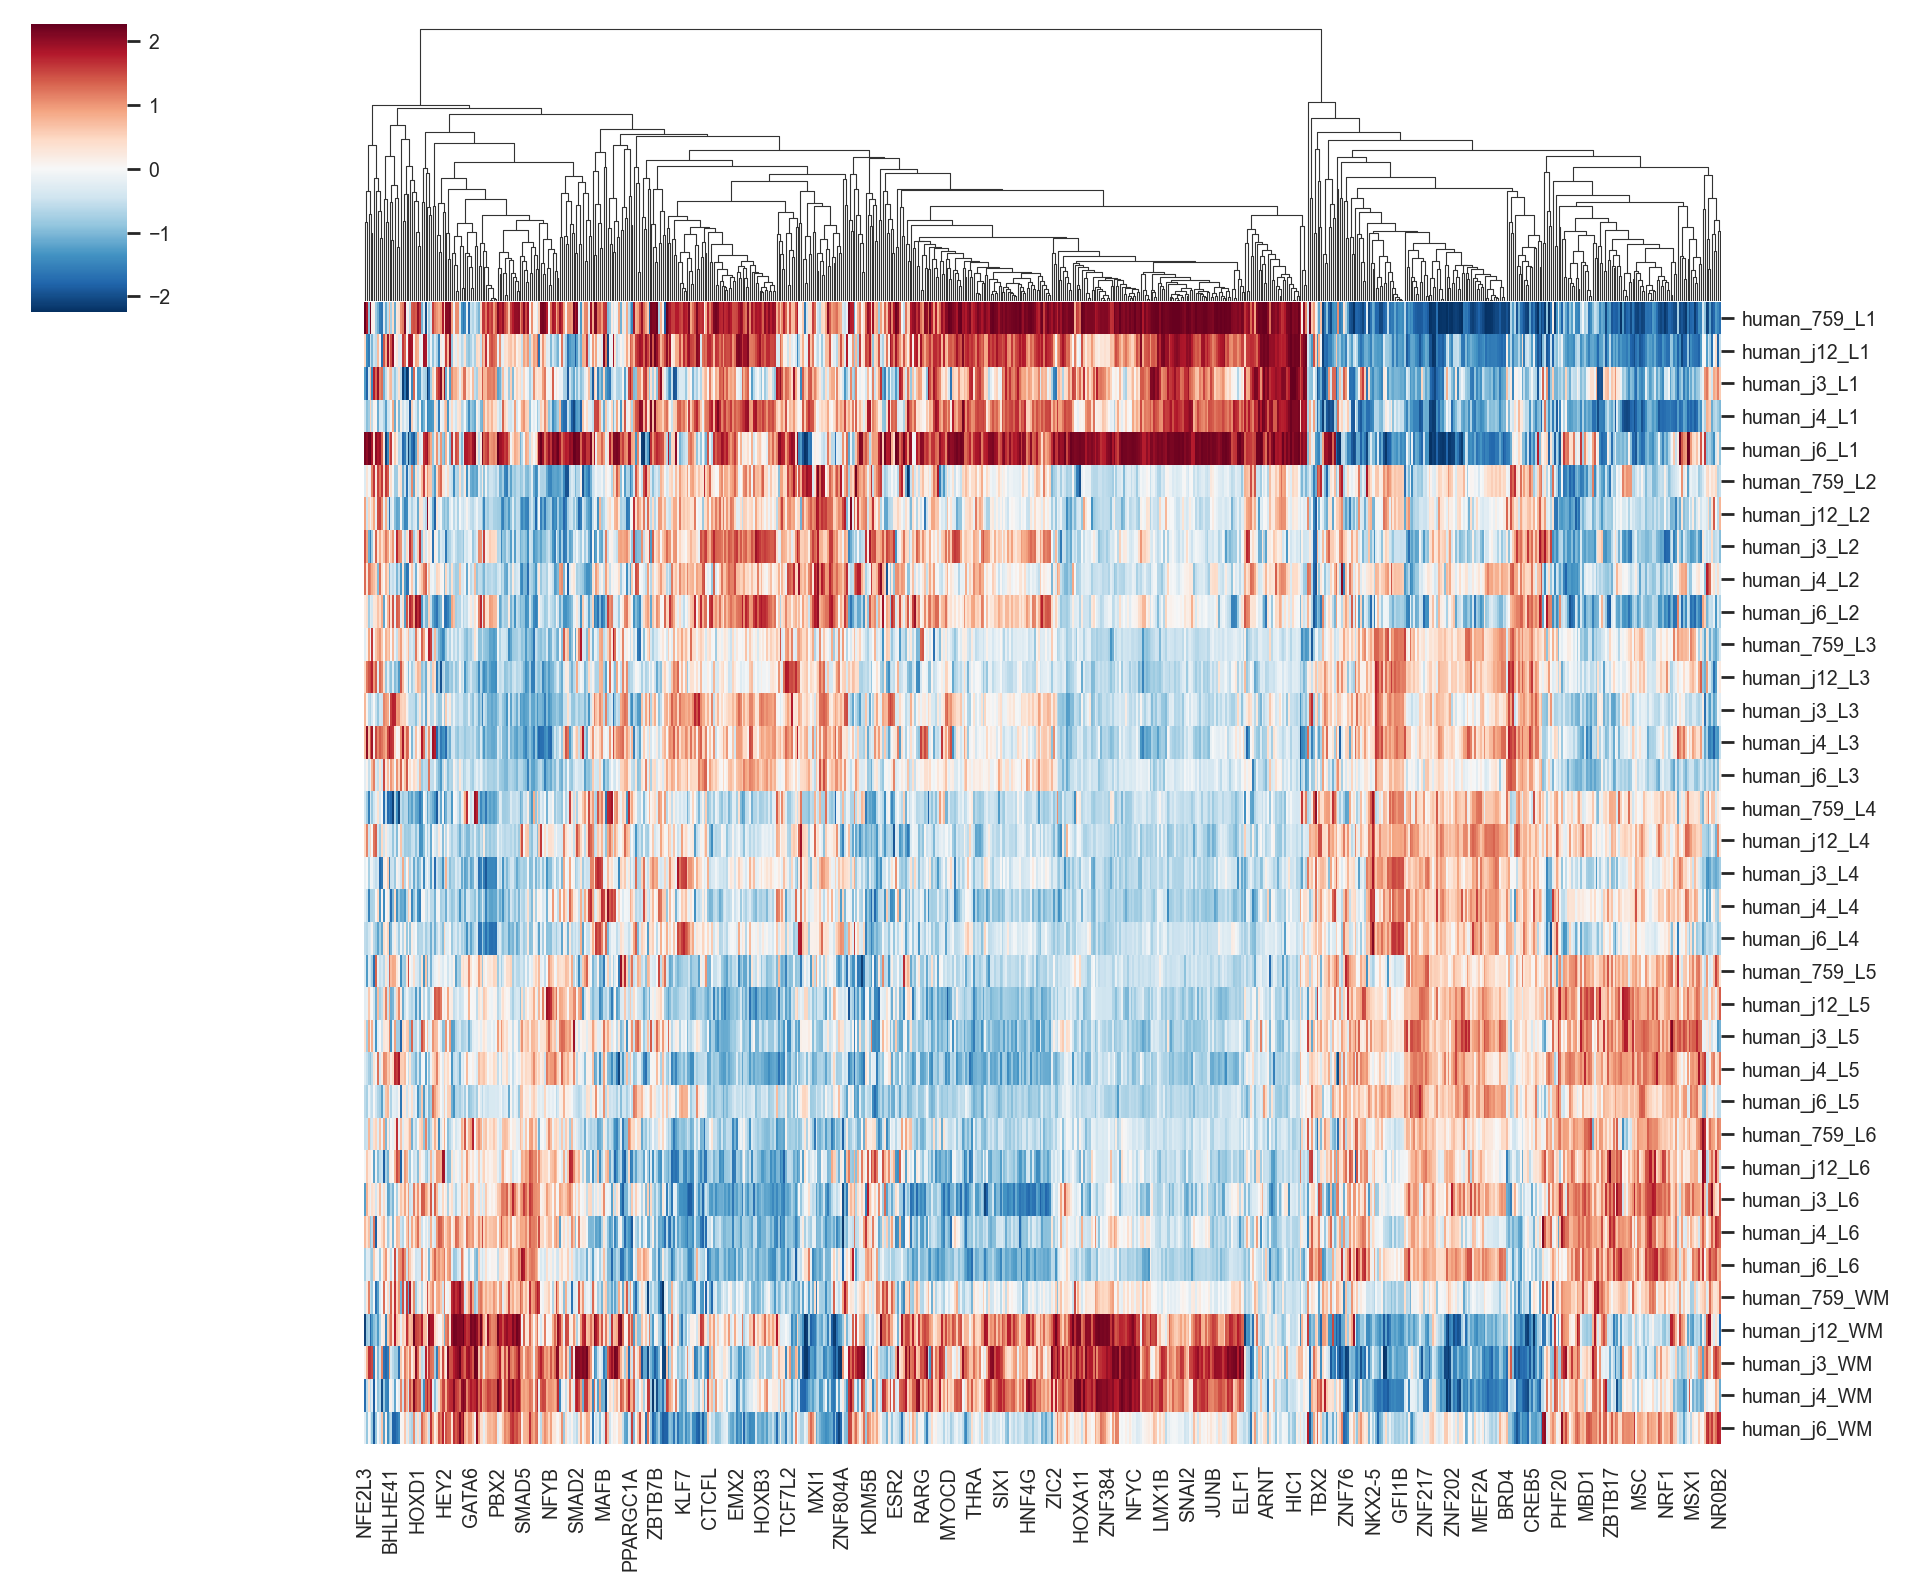

In [18]:
sns.set(font_scale=0.8)
cluster_grid = sns.clustermap(df, figsize=(12, 10), cmap="RdBu_r", center=0, metric='cosine', annot_kws={"size": 2}, row_cluster=False)

<Axes: >

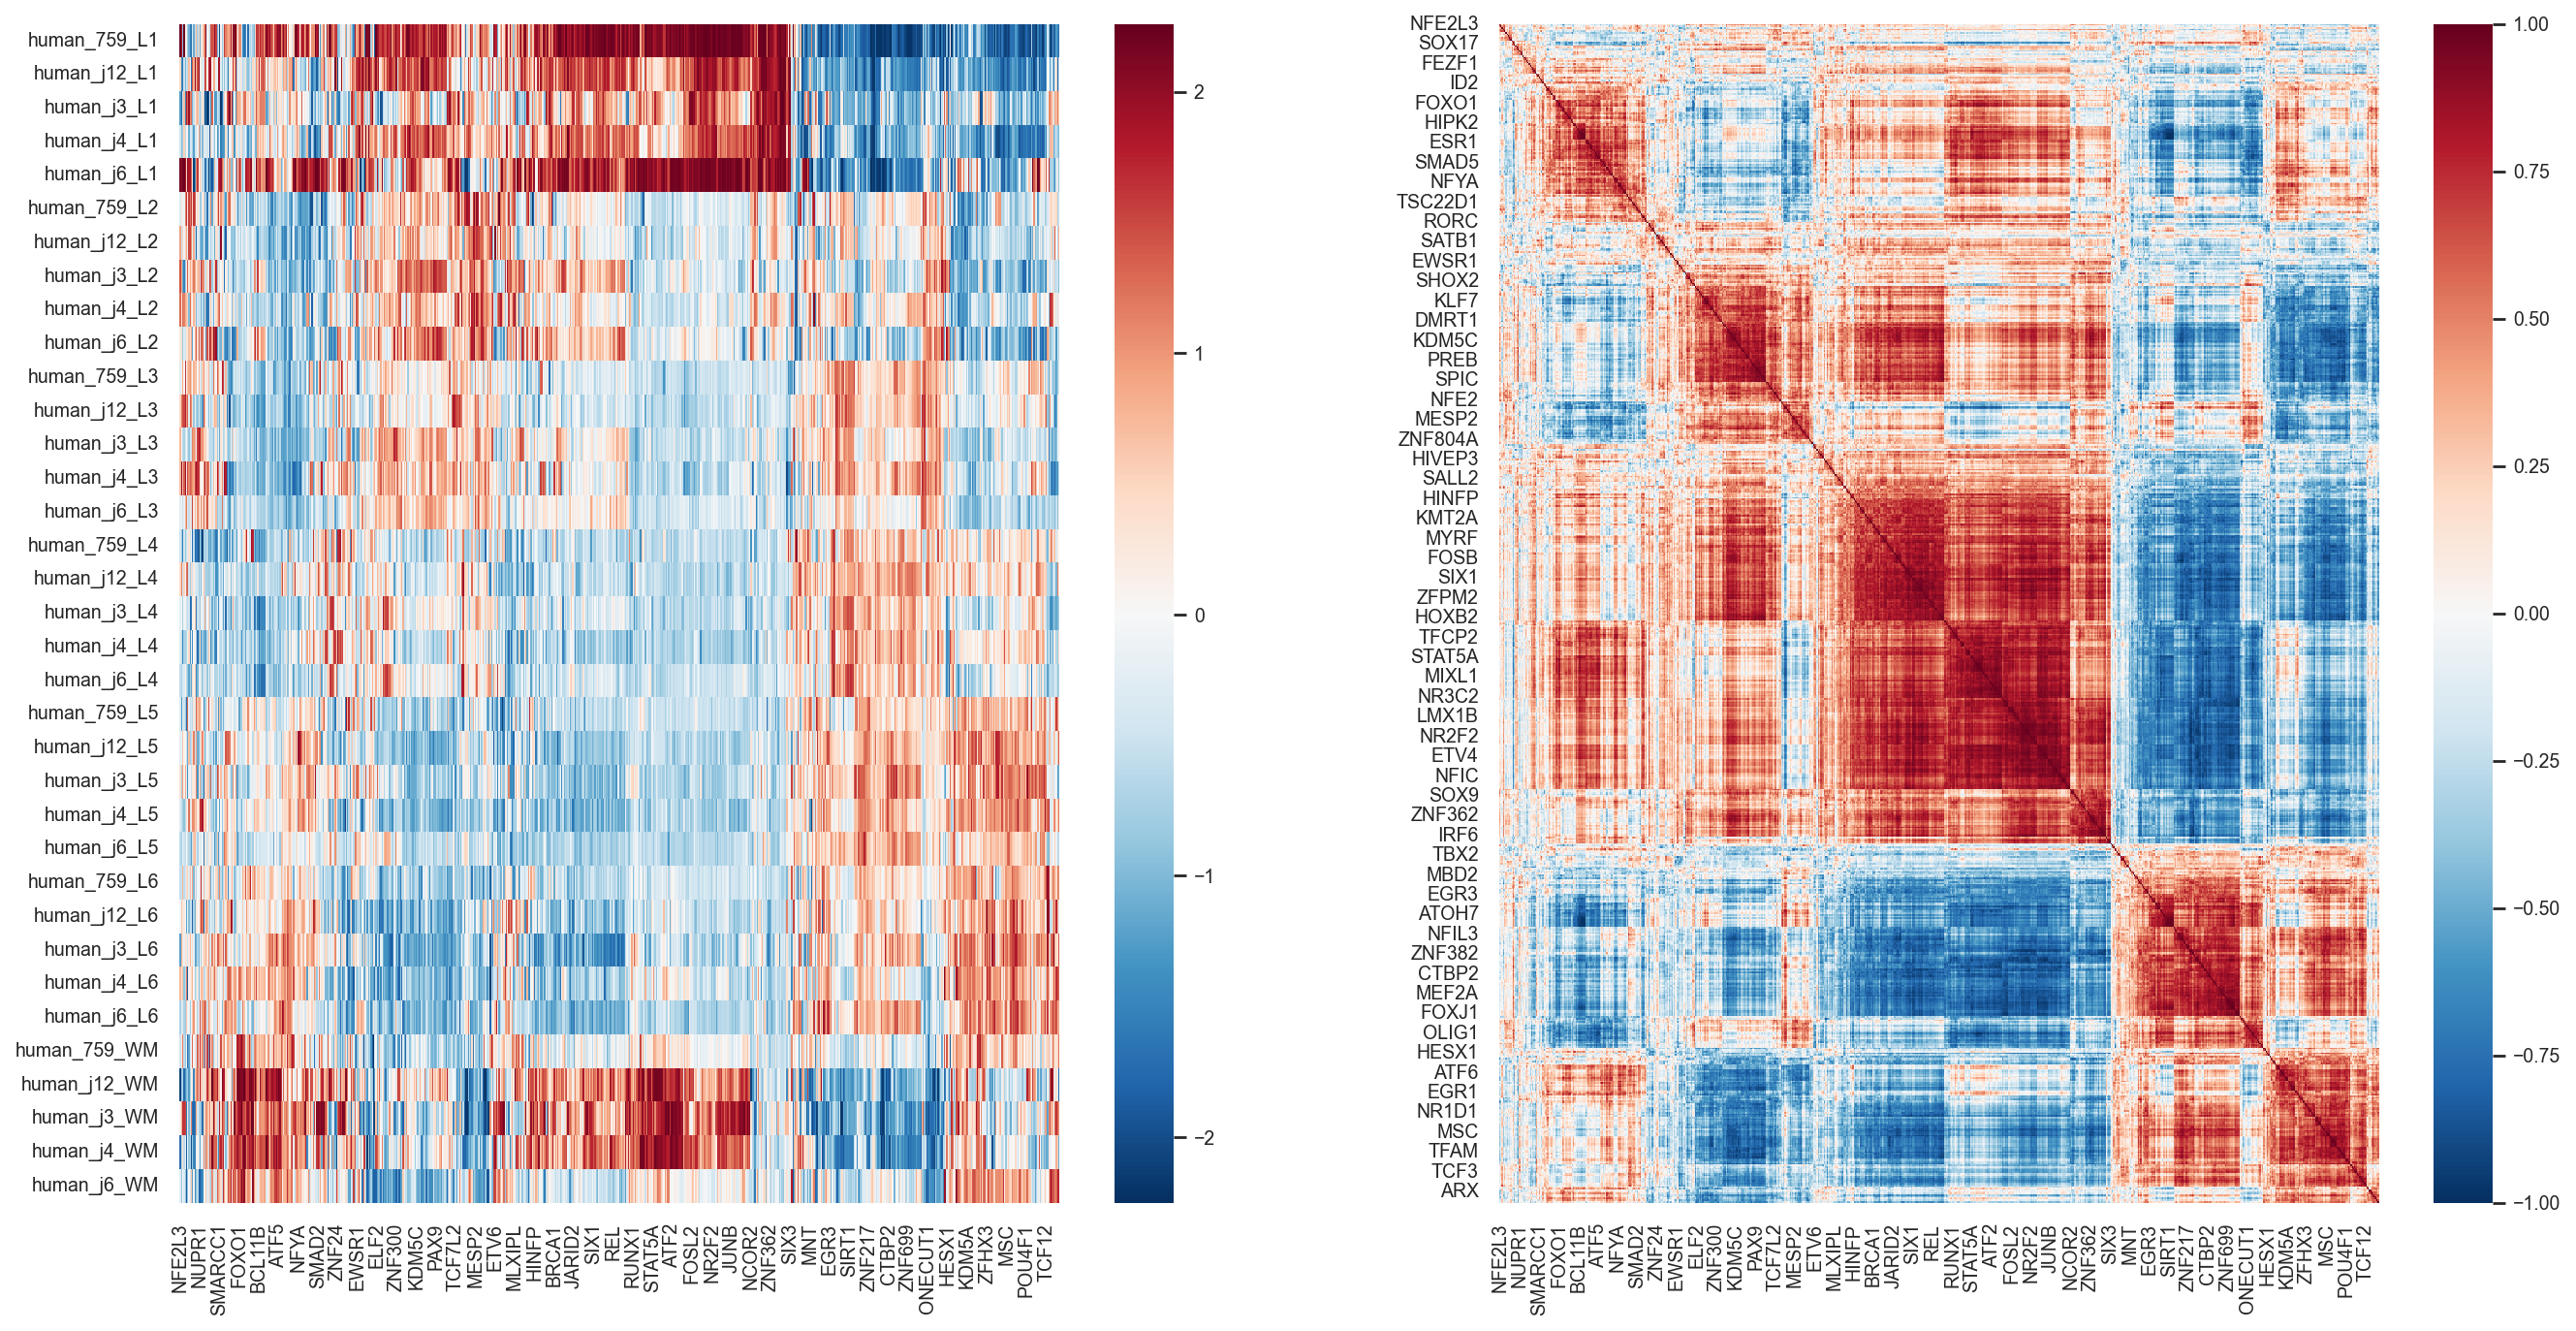

In [19]:
from sklearn.metrics.pairwise import pairwise_kernels
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

gene_order = df.columns[cluster_grid.dendrogram_col.reordered_ind]
sns.heatmap(df[gene_order], cmap="RdBu_r", center=0, cbar=True, ax=ax[0])

aff_matrix = pairwise_kernels(df.T, metric='cosine')
aff_df = pd.DataFrame(aff_matrix, index=df.columns, columns=df.columns)
sns.heatmap(aff_df.loc[gene_order, gene_order], cmap="RdBu_r", center=0, cbar=True, ax=ax[1], vmin=-1, vmax=1)

In [20]:
genes = adata_pb.var_names.intersection(human_specific_genes)
scaled_adata_list = list()

for sample in adata_pb.obs['sample_id'].unique():
    scaled_adata_list.append(sc.pp.scale(adata_pb[adata_pb.obs['sample_id'] == sample, genes], copy=True))

scaled_adata = an.concat(scaled_adata_list , merge='same',uns_merge="unique")
scaled_adata

AnnData object with n_obs × n_vars = 94 × 65
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    layers: 'psbulk_props'

In [21]:
df_prof = pd.DataFrame(scaled_adata.X, index=scaled_adata.obs_names, columns=scaled_adata.var_names)
df_prof = df_prof.loc[sample_order]
df_prof.head()

ALCAM      AMZ2     ASAH1     ASAP2    ATP1A3      CALR  \
human_759_L1 -1.456638 -1.330101 -1.453437 -1.670757 -1.820919 -1.046740   
human_j12_L1 -1.105742 -1.193321 -1.139742 -1.026045 -1.288530 -1.075218   
human_j3_L1  -0.880965 -1.093769 -1.099481 -1.068446 -1.114423 -0.931501   
human_j4_L1  -0.894636 -0.836176 -0.882178 -0.606564 -1.008186 -0.890046   
human_j6_L1  -0.931219 -1.241859 -1.091501 -0.592584 -1.162774 -1.028287   

                 CAMLG      CD47    CHST10    CLSTN1  ...     SULF2   SYNGAP1  \
human_759_L1 -1.443101 -1.820439 -1.094077 -1.744348  ... -1.510544 -1.659957   
human_j12_L1 -1.066514 -1.333701 -1.024052 -1.276606  ... -0.899666 -1.214783   
human_j3_L1  -1.120481 -1.148103 -0.814031 -1.128990  ... -0.652220 -1.151920   
human_j4_L1  -0.824351 -1.085250 -0.575821 -0.967123  ... -1.044034 -0.953620   
human_j6_L1  -1.220611 -1.061664 -1.136884 -1.211519  ... -0.830544 -1.193791   

                TCEAL4     TMED3      TRIR    UBE2V1     VAT1L    ZBTB18  \
human_759_L1 -1.459843 -1.705122 -1.406618 -0.275171 -1.467330 -1.372397   
human_j12_L1 -1.104441 -1.200170 -1.022665 -0.026265 -1.232626 -1.197563   
human_j3_L1  -1.031729 -1.157673 -1.075990 -0.326380 -0.958131 -1.120276   
human_j4_L1  -0.759589 -0.819386 -0.800513 -1.118577 -1.044059 -0.864890   
human_j6_L1  -1.244412 -1.332723 -1.161200 -1.196743 -1.057437 -1.171630   

                ZBTB46    ZNF706  
human_759_L1 -1.876387 -1.308090  
human_j12_L1 -1.234595 -1.147524  
human_j3_L1  -1.194623 -1.099064  
human_j4_L1  -0.862449 -0.889051  
human_j6_L1  -1.102831 -1.199093  

[5 rows x 65 columns]

In [22]:
from scipy.stats import spearmanr, pearsonr, kendalltau

corr_dict = dict()

for gene in tqdm(df_prof.columns):
    gene_dict = dict()
    for tf in df.columns:
        corr = pearsonr(df[tf].values, df_prof[gene].values)
        gene_dict[tf] = corr[0]
    corr_dict[gene] = gene_dict

  0%|          | 0/65 [00:00<?, ?it/s]

In [23]:
df_corr = pd.DataFrame(corr_dict)
df_corr.head()

ALCAM      AMZ2     ASAH1     ASAP2    ATP1A3      CALR     CAMLG  \
ABL1   0.115883  0.024043  0.078691 -0.035375  0.065935  0.099772  0.074499   
AEBP1 -0.743393 -0.723885 -0.729803 -0.707597 -0.782900 -0.721610 -0.738510   
AHR    0.515558  0.097343  0.229720 -0.035399  0.246573  0.160710  0.108639   
AIRE  -0.379991 -0.730922 -0.673788 -0.708769 -0.679066 -0.713535 -0.739485   
AP1   -0.673018 -0.831274 -0.823597 -0.751338 -0.851010 -0.823081 -0.860175   

           CD47    CHST10    CLSTN1  ...     SULF2   SYNGAP1    TCEAL4  \
ABL1   0.035247 -0.052903  0.112343  ... -0.180068  0.072647  0.088275   
AEBP1 -0.835509 -0.551374 -0.796898  ... -0.702036 -0.743466 -0.693990   
AHR    0.384456 -0.203809  0.270079  ...  0.281137  0.215153  0.103559   
AIRE  -0.523611 -0.773031 -0.655072  ... -0.220934 -0.691705 -0.744190   
AP1   -0.817052 -0.724554 -0.874453  ... -0.478094 -0.854614 -0.849064   

          TMED3      TRIR    UBE2V1     VAT1L    ZBTB18    ZBTB46    ZNF706  
ABL1   0.099992  0.035546 -0.159893 -0.059335  0.170719  0.140507  0.096294  
AEBP1 -0.752076 -0.669104 -0.537370 -0.774679 -0.681641 -0.732696 -0.640196  
AHR    0.237408  0.030988 -0.127792  0.450187  0.240963  0.230737  0.014429  
AIRE  -0.670963 -0.759728 -0.604840 -0.386161 -0.647706 -0.622613 -0.735226  
AP1   -0.861614 -0.829290 -0.634963 -0.674377 -0.829446 -0.844526 -0.817397  

[5 rows x 65 columns]

c:\projects\spatialMPFC\venv\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\projects\spatialMPFC\venv\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


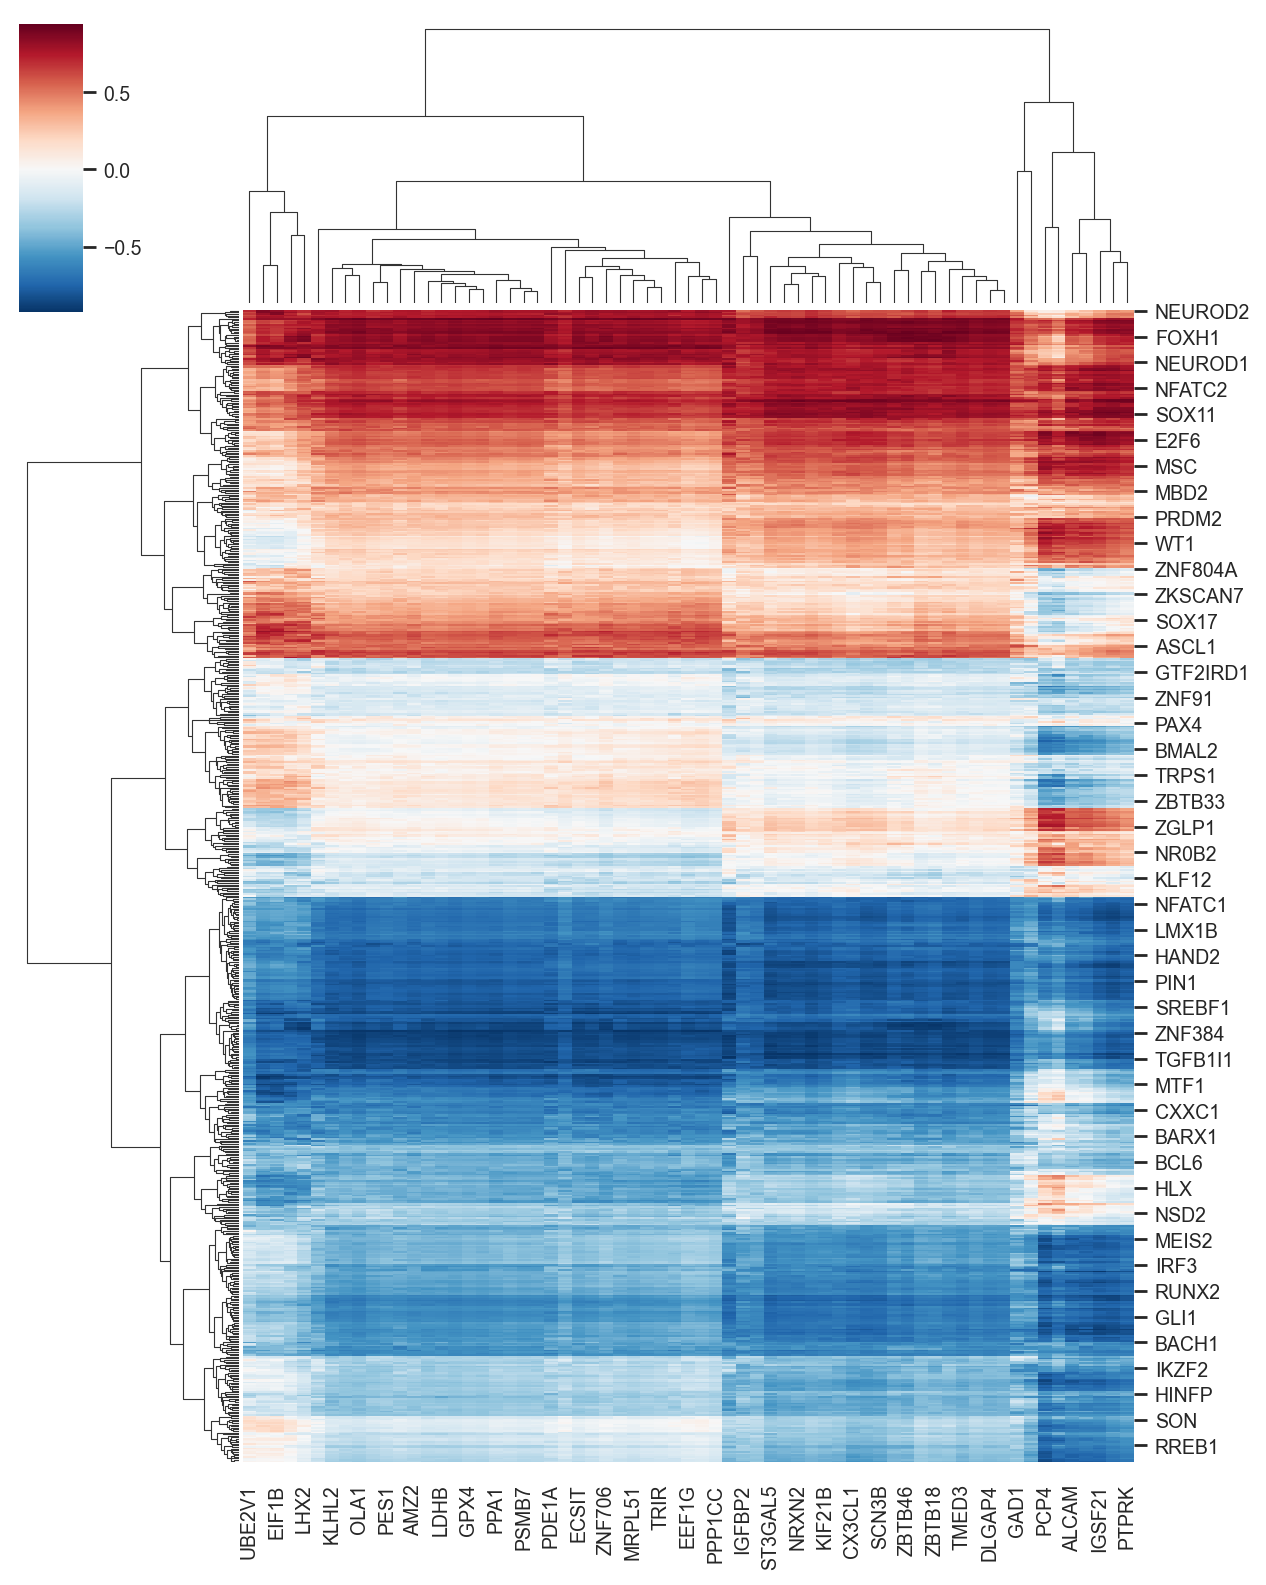

In [24]:
cluster_grid = sns.clustermap(df_corr, figsize=(8, 10), cmap="RdBu_r", center=0, annot_kws={"size": 2}, row_cluster=True)

In [25]:
df_corr.mean(axis=1).sort_values().to_frame(name='correlation').loc['NEUROG2']

correlation    0.773497
Name: NEUROG2, dtype: float64

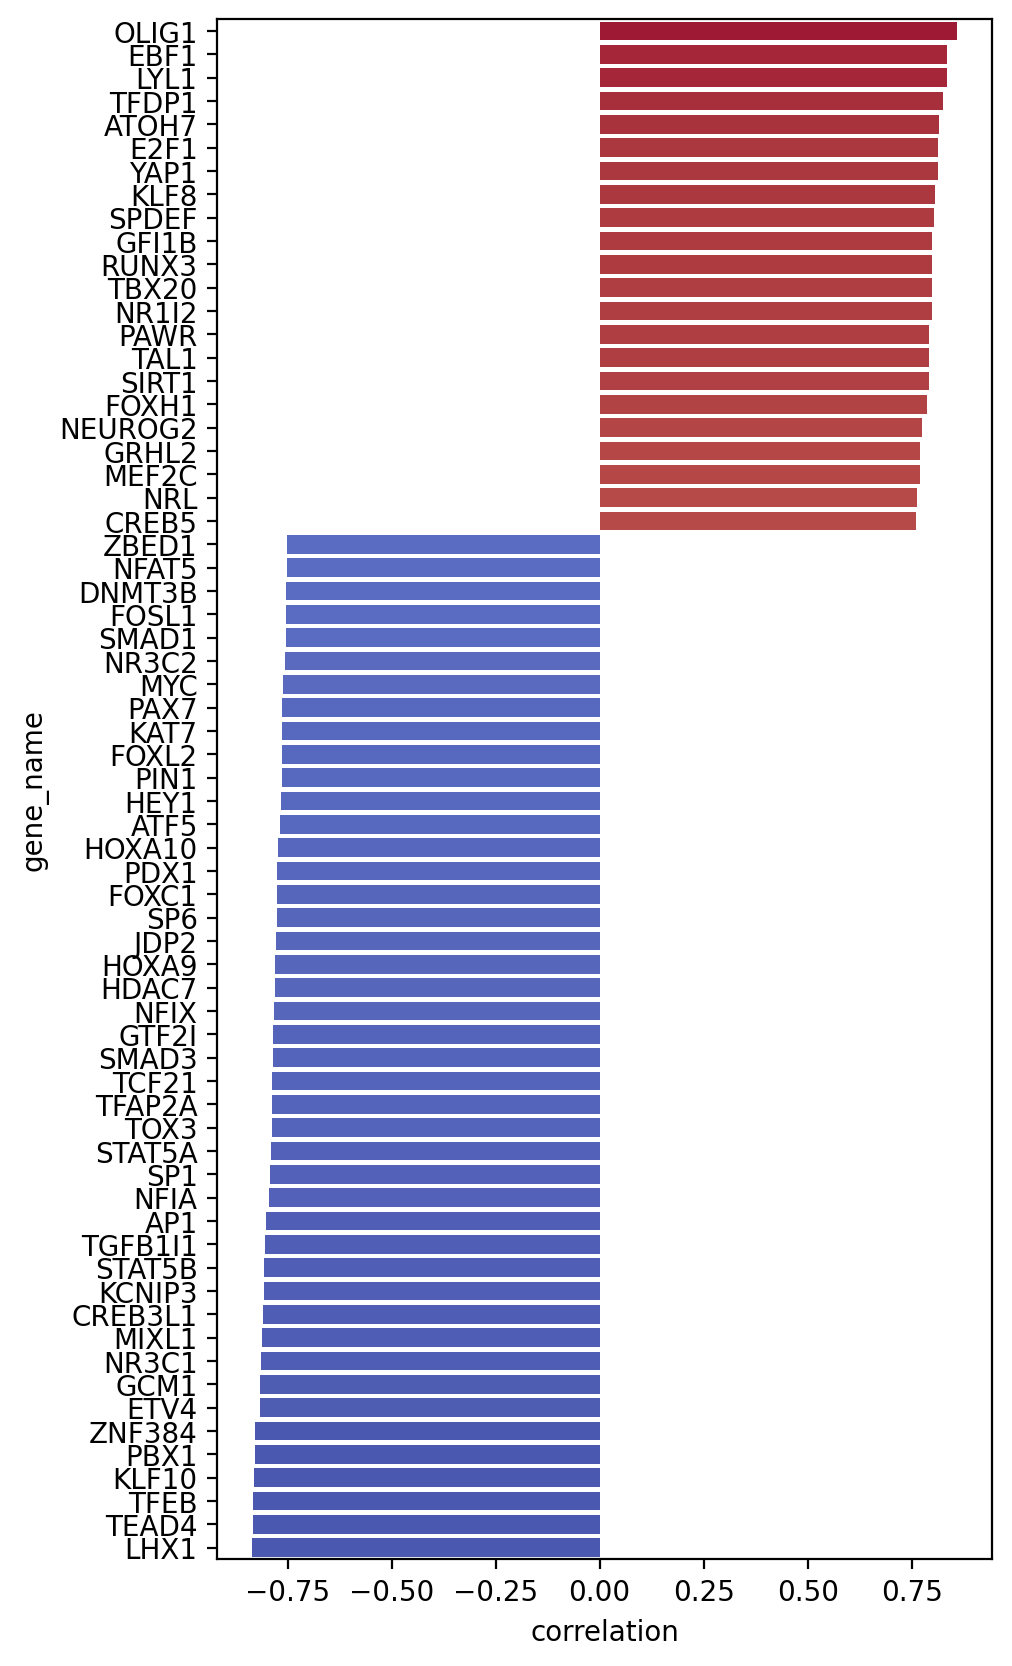

In [26]:
mpl.rcdefaults()

fig = plt.figure(figsize=(5, 10), dpi=100)
palette = sns.color_palette("coolwarm", as_cmap=True)

mean_corr = df_corr.mean(axis=1).sort_values().to_frame(name='correlation').reset_index(names='gene_name')
mean_corr = mean_corr[mean_corr.correlation.abs() > 0.75].sort_values('correlation', ascending=False)
ax = sns.barplot(mean_corr, x='correlation', y='gene_name', hue='correlation', palette=palette)
ax.grid(False)
ax.get_legend().remove()

In [27]:
mean_corr = df_corr.mean(axis=1).sort_values().to_frame(name='correlation').reset_index(names='gene_name')
mean_corr.head()

gene_name  correlation
0      LHX1    -0.834351
1     TEAD4    -0.833941
2      TFEB    -0.832472
3     KLF10    -0.830707
4      PBX1    -0.828488

In [28]:
corr_coll = collectri[collectri.source.isin(mean_corr.gene_name.tolist())]
corr_coll = corr_coll.sort_values('source')
corr_coll = corr_coll[corr_coll.target.isin(hs_groups.index.tolist())]
corr_coll

source  target  weight               PMID
37092     AHR     LPL       1           18827440
42096     AP1     LPL       1  11916942;12882931
42627     AP1  PPP1CC       1            1851743
43128     AP1  IGFBP2       1            9032395
14019      AR    PPA1       1           18212046
...       ...     ...     ...                ...
34620     YY1    CALR       1           19659458
17062  ZBTB16     ID2       1           19723763
40701  ZBTB18     ID2      -1           22234186
19070  ZNF263    GAD1       1           20869372
22872  ZNF699    GAD1       1           22832356

[206 rows x 4 columns]

In [29]:
act_dir = corr_coll[['source', 'weight']].groupby('source').mean()
act_dir = act_dir[act_dir.weight.abs() == 1]
act_dir.shape

(135, 1)

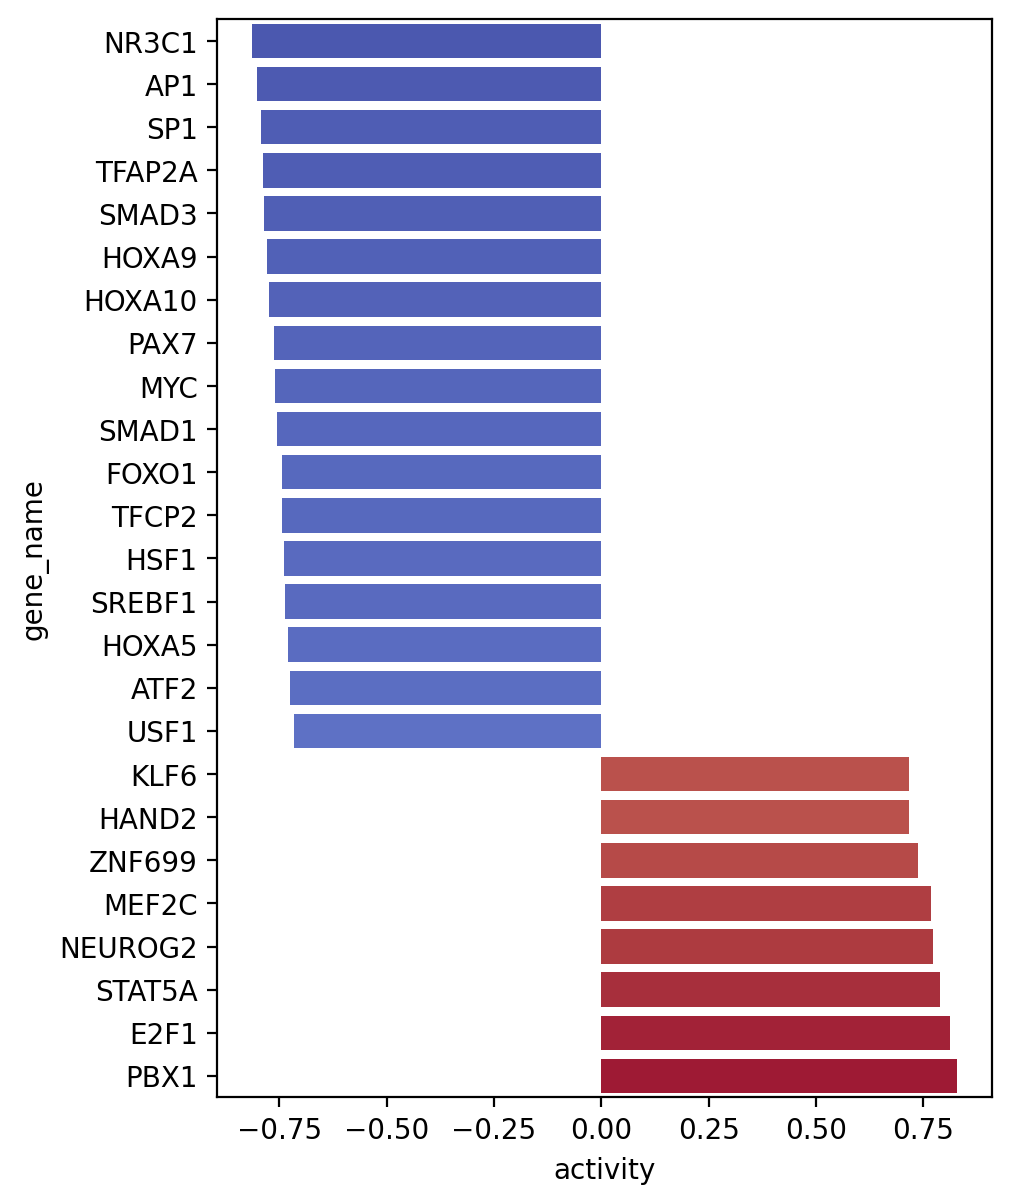

In [30]:
mpl.rcdefaults()

fig = plt.figure(figsize=(5, 7), dpi=100)
palette = sns.color_palette("coolwarm", as_cmap=True)
mean_corr_plot = mean_corr.set_index('gene_name').loc[act_dir.index.tolist()].copy()
mean_corr_plot['activity'] = mean_corr_plot['correlation'] * act_dir.weight
mean_corr_plot_top = mean_corr_plot.sort_values('activity', key=np.abs, ascending=False).head(25).sort_values('activity')
mean_corr_plot_top
ax = sns.barplot(mean_corr_plot_top.reset_index(), x='activity', y='gene_name', hue='activity', palette=palette)
ax.grid(False)
ax.get_legend().remove()

In [31]:
df_corr_t = df_corr[hs_groups.index].T
df_corr_t['group'] = hs_groups['label']
mean_corr = df_corr_t.groupby('group').mean()
mean_corr.head()

ABL1     AEBP1       AHR      AIRE       AP1  \
group                                                                    
age-specific          0.065983 -0.717817  0.154696 -0.676860 -0.819160   
human-specific        0.045899 -0.689717  0.106666 -0.688008 -0.792933   
maybe age-specific    0.050788 -0.698961  0.184670 -0.616139 -0.765817   
maybe human-specific  0.044271 -0.720429  0.154947 -0.678420 -0.811517   

                         APEX1        AR    ARID1A    ARID1B    ARID3A  ...  \
group                                                                   ...   
age-specific         -0.354148  0.262417  0.036326  0.345150 -0.259427  ...   
human-specific       -0.385083  0.180617  0.028408  0.287011 -0.193817  ...   
maybe age-specific   -0.247145  0.271075 -0.028473  0.359383 -0.305652  ...   
maybe human-specific -0.340657  0.249442  0.014156  0.339172 -0.260627  ...   

                        ZNF362    ZNF382    ZNF384    ZNF395    ZNF423  \
group                                                                    
age-specific         -0.368186  0.542498 -0.845495  0.021059 -0.351784   
human-specific       -0.286612  0.480788 -0.835897  0.094786 -0.276015   
maybe age-specific   -0.376006  0.521555 -0.783528 -0.022122 -0.371974   
maybe human-specific -0.355588  0.529522 -0.838939  0.028486 -0.342514   

                        ZNF436    ZNF699     ZNF76   ZNF804A     ZNF91  
group                                                                   
age-specific          0.291371  0.754447  0.567152  0.098234 -0.173335  
human-specific        0.236247  0.710401  0.567591  0.099170 -0.161403  
maybe age-specific    0.322455  0.723588  0.563007  0.028340 -0.193158  
maybe human-specific  0.301549  0.741331  0.564905  0.080792 -0.183402  

[4 rows x 715 columns]

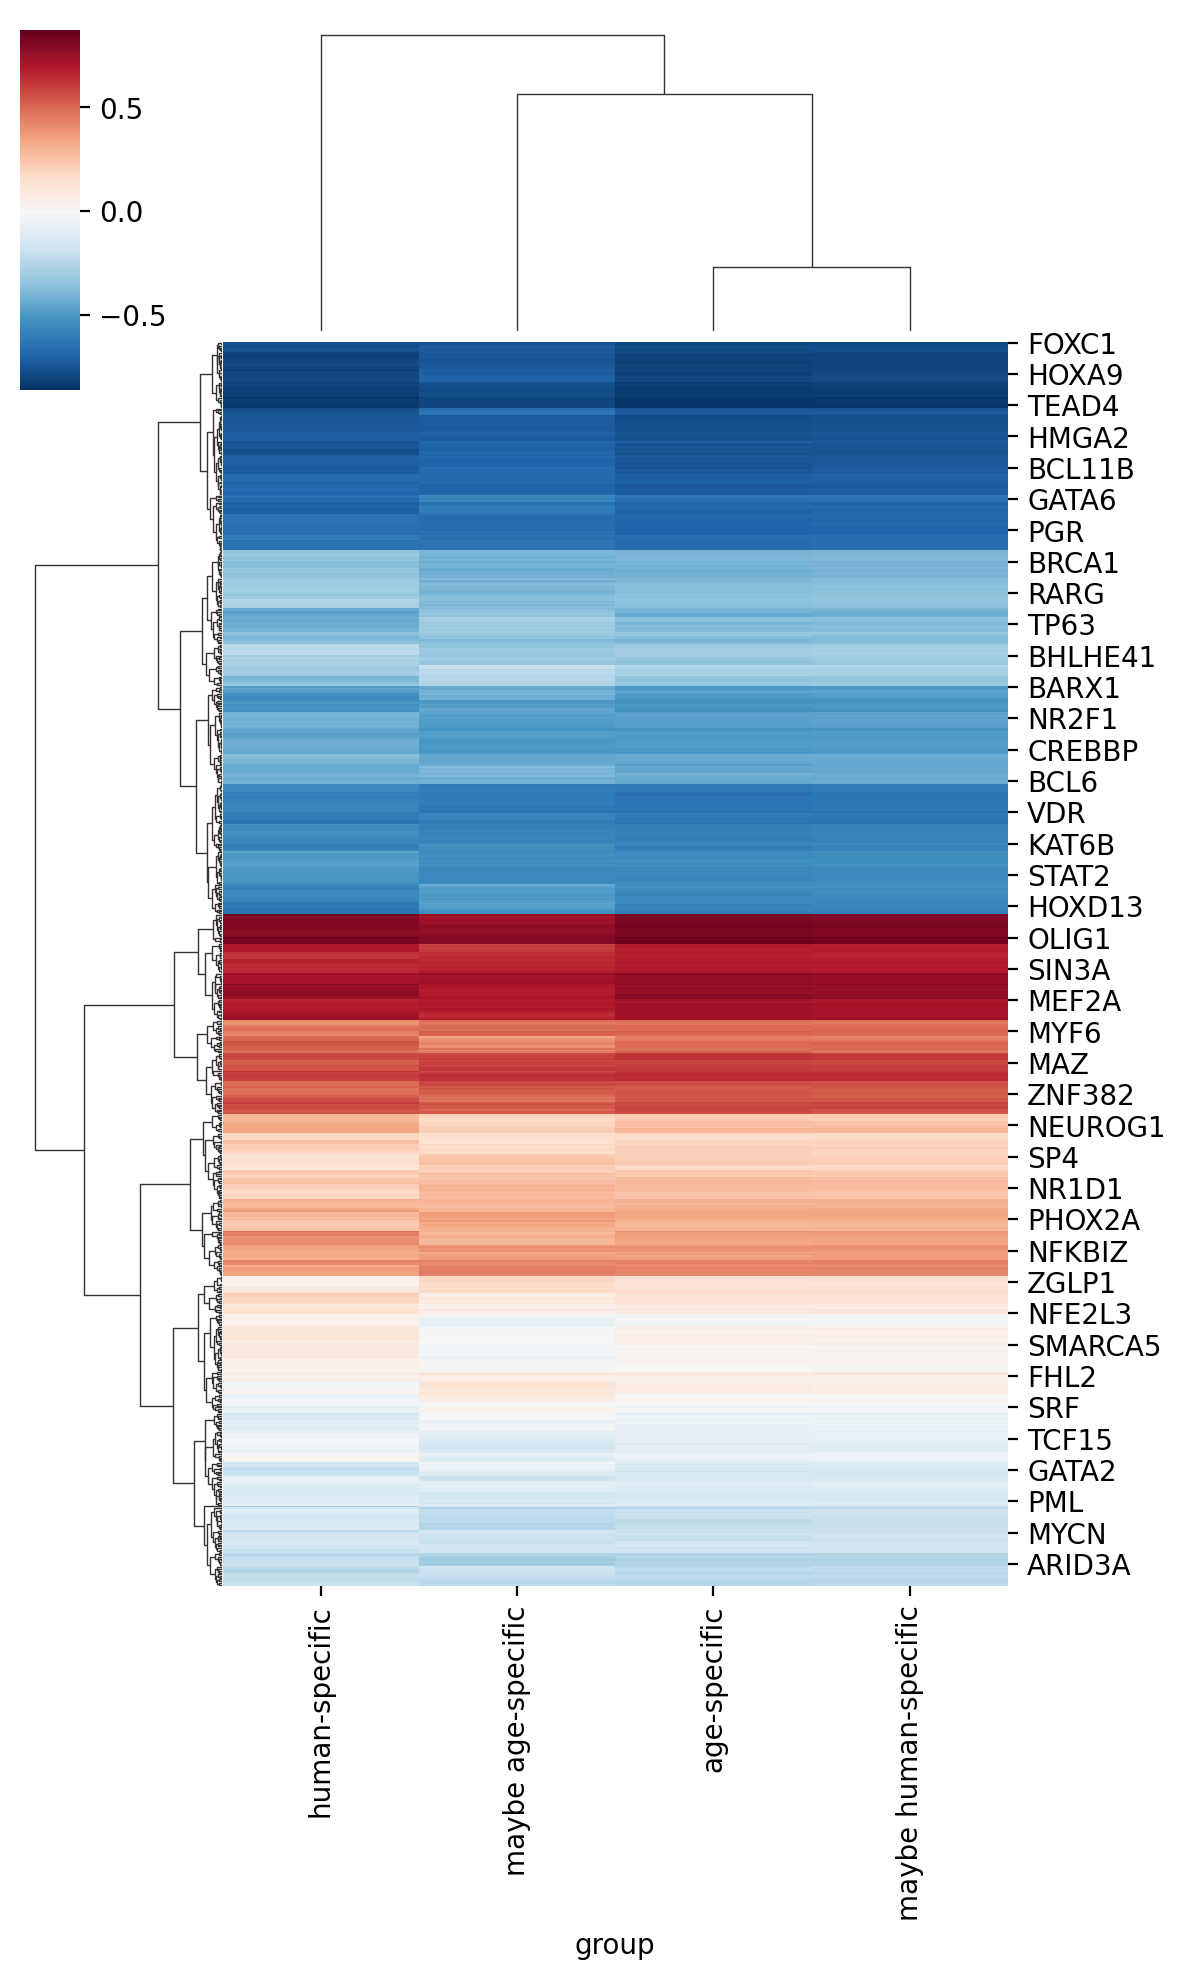

In [32]:
cluster_grid = sns.clustermap(mean_corr.T, figsize=(6, 10), cmap="RdBu_r", center=0, annot_kws={"size": 2}, row_cluster=True)

In [33]:
df_corr_t = df_corr[cluster_groups.index].T
df_corr_t['group'] = cluster_groups['label']
mean_corr = df_corr_t.groupby('group').mean()
mean_corr.head()

ABL1     AEBP1       AHR      AIRE       AP1     APEX1        AR  \
group                                                                         
0      0.096514 -0.742035  0.241936 -0.654475 -0.831273 -0.329482  0.355157   
1      0.046016 -0.689059  0.081368 -0.718644 -0.814854 -0.416444  0.156066   
2     -0.005180 -0.746733  0.092710 -0.720303 -0.846306 -0.384350  0.209169   
3      0.044317 -0.700993  0.168736 -0.602006 -0.744324 -0.208313  0.259401   
4      0.061132 -0.786097  0.396114 -0.483227 -0.758196  0.025227  0.531968   

         ARID1A    ARID1B    ARID3A  ...    ZNF362    ZNF382    ZNF384  \
group                                ...                                 
0      0.030385  0.421092 -0.332817  ... -0.431001  0.584245 -0.862370   
1      0.035323  0.245751 -0.153720  ... -0.269856  0.471177 -0.854065   
2      0.030804  0.293138 -0.228019  ... -0.359496  0.559495 -0.863309   
3     -0.069308  0.386862 -0.317767  ... -0.361829  0.509438 -0.771503   
4     -0.122585  0.606497 -0.595924  ... -0.620919  0.672043 -0.730182   

         ZNF395    ZNF423    ZNF436    ZNF699     ZNF76   ZNF804A     ZNF91  
group                                                                        
0     -0.032636 -0.419641  0.341171  0.808565  0.575271  0.077948 -0.217959  
1      0.116433 -0.246084  0.221210  0.703131  0.565103  0.143827 -0.132187  
2      0.052051 -0.327456  0.281743  0.736172  0.574573  0.085792 -0.143995  
3     -0.026535 -0.382877  0.351672  0.727904  0.569066 -0.003255 -0.215227  
4     -0.287347 -0.648890  0.566443  0.832553  0.594602 -0.161628 -0.303579  

[5 rows x 715 columns]

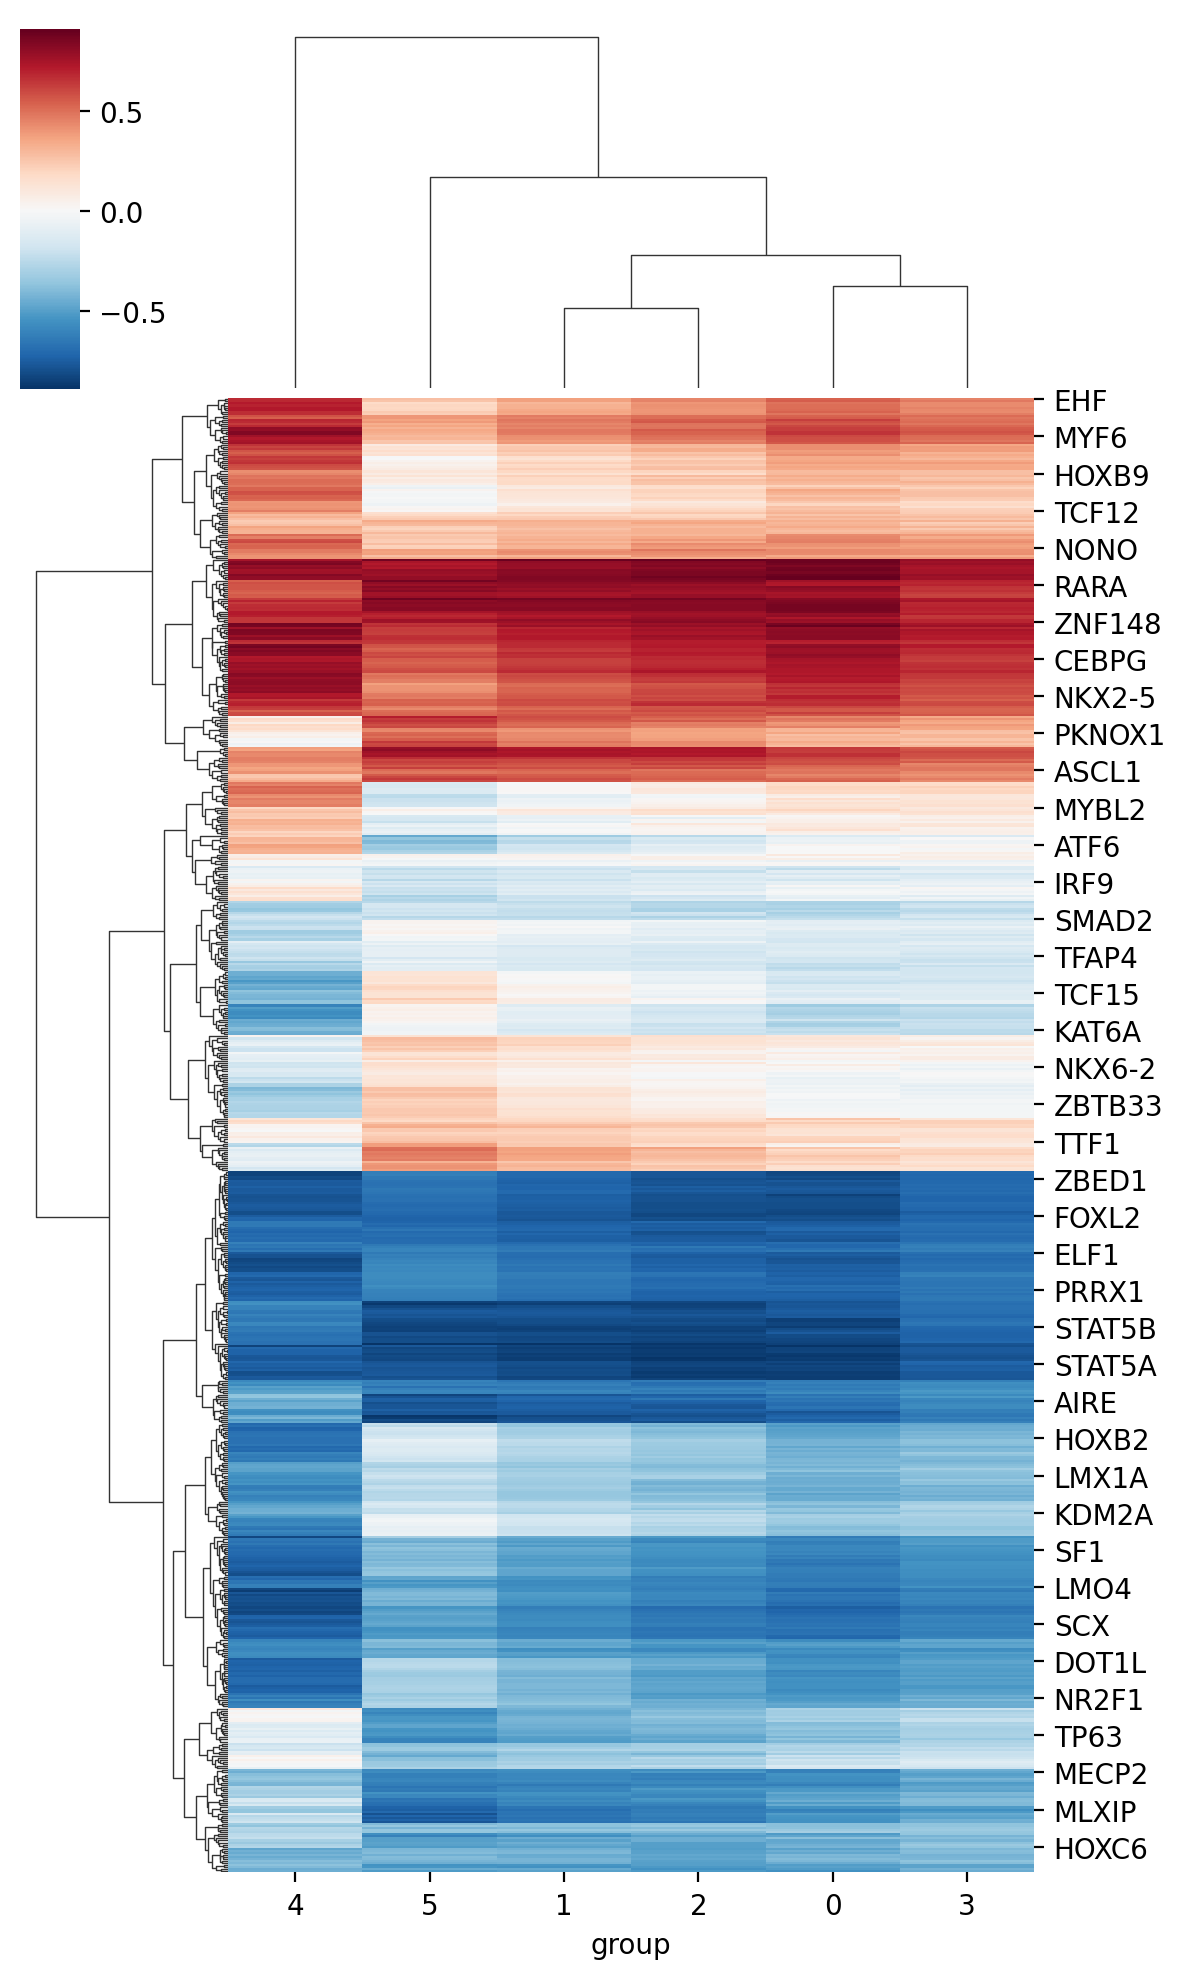

In [34]:
cluster_grid = sns.clustermap(mean_corr.T, figsize=(6, 10), cmap="RdBu_r", center=0, annot_kws={"size": 2}, row_cluster=True)

# Approach 2

## Specie-specific genes

In [35]:
from statsmodels.stats.multitest import multipletests
import pandas as pd
res_dict = dict()
res_dict['human-chimp'] = pd.read_csv('../Specie-specific genes/results/edgeR_human_chimp.csv', index_col=0)
res_dict['human-macaque'] = pd.read_csv('../Specie-specific genes/results/edgeR_human_macaque.csv', index_col=0)
res_dict['chimp-macaque'] = pd.read_csv('../Specie-specific genes/results/edgeR_chimp_macaque.csv', index_col=0)

for key, df in res_dict.items():
    mult_test = multipletests(df['PValue'], method='fdr_bh')
    df['p_val_adj'] = mult_test[1]

res_dict['human-chimp'].head()

logFC.spline_1.human  logFC.spline_2.human  logFC.spline_3.human  \
A1BG               0.244038              0.286535              0.252427   
AACS              -0.388070             -0.241365             -0.039750   
AADAT             -0.399771             -0.369816             -0.361727   
AAGAB              0.086928              0.361438              0.044400   
AAK1               0.231119              0.421302              0.032839   

         logCPM         F    PValue  p_val_adj  
A1BG   8.937955  1.353039  0.266747   0.847434  
AACS   8.898749  1.925657  0.131096   0.624955  
AADAT  8.822620  0.269978  0.846744   1.000000  
AAGAB  8.837510  0.579746  0.630315   1.000000  
AAK1   8.977608  0.409947  0.746269   1.000000

In [36]:
df_padj = res_dict['human-chimp']['F'].to_frame(name='human-chimp')
df_padj['human-macaque'] = res_dict['human-macaque']['F']
df_padj['chimp-macaque'] = res_dict['chimp-macaque']['p_val_adj']
df_padj['min F'] = df_padj[['human-chimp', 'human-macaque']].min(axis=1)
df_padj = df_padj[df_padj['chimp-macaque'] >= 0.05].sort_values('min F', ascending=False)
df_padj

human-chimp  human-macaque  chimp-macaque         min F
LPL      2.039966e+01   2.357270e+01       0.252272  2.039966e+01
PTPRK    1.720457e+01   2.548007e+01       0.525999  1.720457e+01
ZBTB18   1.446414e+01   1.835879e+01       0.122002  1.446414e+01
ERC1     1.159980e+01   1.042552e+01       1.000000  1.042552e+01
IGFBP6   1.017093e+01   1.193283e+01       0.930408  1.017093e+01
...               ...            ...            ...           ...
ASB13    1.294369e+00  -5.710887e-08       1.000000 -5.710887e-08
STRIP2  -5.872595e-08   9.863464e-01       1.000000 -5.872595e-08
GOLGA2  -5.994179e-08   2.641182e+00       1.000000 -5.994179e-08
GNAI2    2.904467e+00  -6.642220e-08       1.000000 -6.642220e-08
DENND11 -1.062789e-07   1.555084e+00       1.000000 -1.062789e-07

[6733 rows x 4 columns]

In [37]:
mat = df_padj['min F'].to_frame().T
mat

LPL      PTPRK     ZBTB18       ERC1     IGFBP6    IGFBP2  \
min F  20.399662  17.204569  14.464137  10.425521  10.170926  9.886667   

          ALCAM    IGSF21     ASAP2     COTL1  ...         AHDC1  \
min F  9.709994  9.523161  9.436718  9.280476  ... -3.639917e-08   

              IL17D         SSBP1         KRIT1        TRIM69         ASB13  \
min F -3.641628e-08 -3.664264e-08 -3.804714e-08 -4.570227e-08 -5.710887e-08   

             STRIP2        GOLGA2         GNAI2       DENND11  
min F -5.872595e-08 -5.994179e-08 -6.642220e-08 -1.062789e-07  

[1 rows x 6733 columns]

In [38]:
# Infer TF activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri, verbose=True)
tf_acts

2 features of mat are empty, they will be removed.
Running ulm on mat with 1 samples and 6731 targets for 455 sources.


AHR      AIRE       AP1     APEX1        AR    ARID4A    ARID4B  \
min F  3.639606  0.114881  1.503413 -0.363507  2.192116 -0.698203  0.929749   

           ARNT       ARX     ASCL1  ...   ZKSCAN7    ZNF143    ZNF148  \
min F  0.560821 -0.215061  0.897197  ... -1.007003  0.812713 -0.558312   

         ZNF263    ZNF331    ZNF362    ZNF384    ZNF436   ZNF699     ZNF91  
min F  1.470131 -1.012192 -0.792774  0.747849 -0.746385  0.96853  0.215956  

[1 rows x 455 columns]

In [39]:
tf_pvals_tr = tf_pvals[tf_pvals < 0.05].dropna(axis=1)
tf_pvals_tr

AHR        AR      ATF3     CEBPE     CREB1      CTCF     CXXC1  \
min F  0.000275  0.028405  0.035756  0.009008  0.020615  0.041226  0.018272   

           DLX1      DLX2      EGR1  ...     SMAD4   SMARCA1       SP1  \
min F  0.002307  0.022431  0.028068  ...  0.002422  0.000141  0.004359   

          STAT1         TBPL2      TET1    TFAP2A     TFCP2      TP53  \
min F  0.000618  6.423460e-13  0.028524  0.007725  0.025964  0.023226   

           TTF1  
min F  0.003994  

[1 rows x 53 columns]

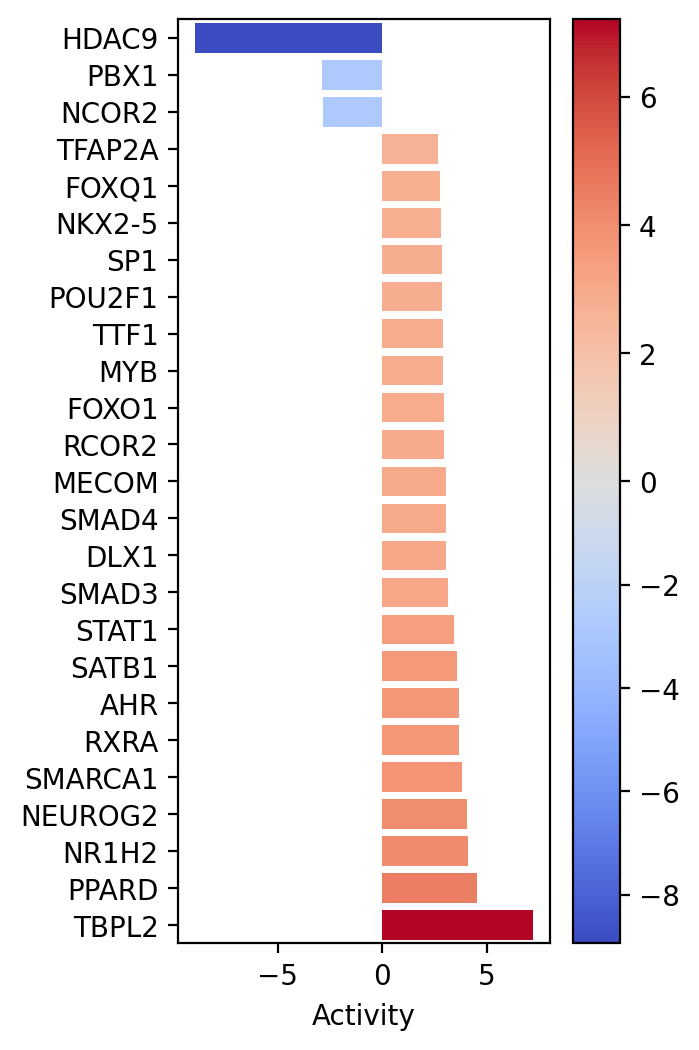

In [40]:
dc.plot_barplot(
    acts=tf_acts[tf_pvals_tr.columns],
    contrast='min F',
    top=25,
    vertical=True,
    figsize=(3, 6)
)

In [41]:
tf_acts[tf_pvals_tr.columns]

AHR        AR      ATF3     CEBPE    CREB1      CTCF     CXXC1  \
min F  3.639606  2.192116  2.100108  2.612492  2.31551  2.041646  2.360643   

           DLX1      DLX2      EGR1  ...     SMAD4   SMARCA1       SP1  \
min F  3.048796  2.283519  2.196804  ...  3.034116  3.808851  2.851926   

          STAT1     TBPL2      TET1    TFAP2A     TFCP2      TP53      TTF1  
min F  3.425133  7.205285  2.190478  2.664643  2.227237  2.270211  2.879623  

[1 rows x 53 columns]

<Axes: xlabel='enrichment', ylabel='correlation'>

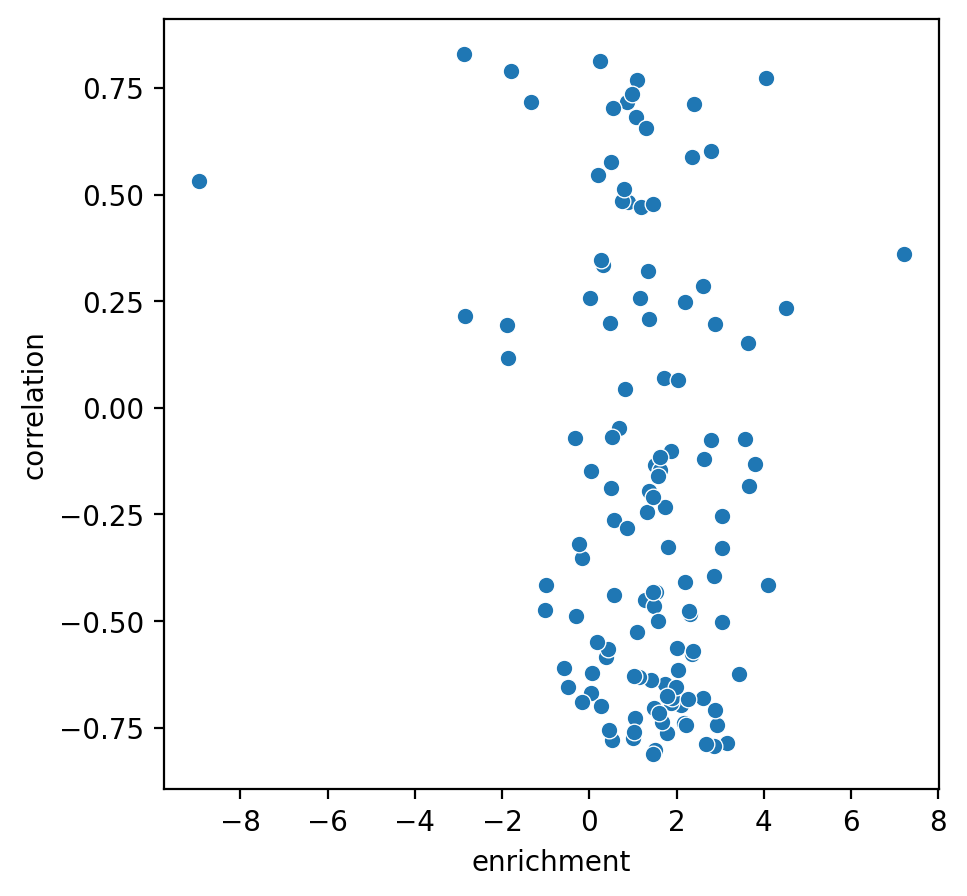

In [42]:
mpl.rcdefaults()

fig = plt.figure(figsize=(5, 5), dpi=100)

inter = tf_acts.columns.intersection(mean_corr_plot.index)
corr_df = tf_acts[inter].T
corr_df['correlation'] = mean_corr_plot.loc[inter, 'activity']
corr_df.columns = ['enrichment', 'correlation']

sns.scatterplot(corr_df, x='enrichment', y='correlation')

In [43]:
spearmanr(corr_df['enrichment'], corr_df['correlation'])

SignificanceResult(statistic=-0.18268016497937759, pvalue=0.04061828074234732)

# Approach 3 (ORA)

In [15]:
len(human_specific_genes)

65

In [19]:
# Run ora
enr_pvals = dc.get_ora_df(
    df=human_specific_genes,
    net=collectri,
    source='source',
    target='target'
)

enr_pvals.head()

Term  Set size  Overlap ratio   p-value  FDR p-value  Odds ratio  \
0    AHR       194       0.005155  0.469852     0.518219    2.368207   
1    AP1       596       0.005034  0.305954     0.401837    1.821713   
2     AR       514       0.003891  0.500616     0.540233    1.491127   
3   ARNT        69       0.014493  0.201483     0.328504    6.669399   
4  ASCL1        72       0.013889  0.209270     0.331577    6.392462   

   Combined score           Features  
0        1.788797                LPL  
1        2.157490  IGFBP2;LPL;PPP1CC  
2        1.031735          CALR;PPA1  
3       10.684726               GAD1  
4        9.998640               GAD1

In [17]:
enr_pvals.sort_values('FDR p-value')

Term  Set size  Overlap ratio   p-value  FDR p-value  Odds ratio  \
48     HOXA2         7       0.142857  0.022533     0.222254   61.995349   
90     OVOL1        10       0.100000  0.032036     0.222254   44.275748   
130     TCF4        58       0.034483  0.015294     0.222254   13.421159   
83    NKX2-5        74       0.027027  0.024175     0.222254   10.530307   
97   POU2AF1         5       0.200000  0.016146     0.222254   84.547569   
..       ...       ...            ...       ...          ...         ...   
88     NR3C1       292       0.003425  0.616164     0.633045    1.566965   
80      NFKB       799       0.002503  0.738759     0.753836    0.945547   
81     NFKB1       433       0.002309  0.759495     0.769758    1.049730   
45     HIF1A       463       0.002160  0.782360     0.787610    0.980281   
27      ESR1       634       0.001577  0.877210     0.877210    0.709825   

     Combined score      Features  
48       235.135107          PCP4  
90       152.348355           ID2  
130       56.104509     ID2;NRXN1  
83        39.198210      CALR;ID2  
97       348.848595           ID2  
..              ...           ...  
88         0.758790           LPL  
80         0.286296  ALCAM;IGFBP2  
81         0.288783           LPL  
45         0.240601           ID2  
27         0.092993           LPL  

[150 rows x 8 columns]

# Approach 4 (ANCOVA)

## Generate data

In [47]:
# Infer pathway activities with ulm
dc.run_ulm(
    mat=adata_pb,
    net=collectri,
    source='source',
    target='target',
    weight='weight',
    verbose=True,
    use_raw=False
)

Running ulm on mat with 94 samples and 14963 targets for 723 sources.


In [48]:
acts = dc.get_acts(adata_pb, obsm_key='ulm_estimate')
acts

AnnData object with n_obs × n_vars = 94 × 723
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition'
    obsm: 'ulm_estimate', 'ulm_pvals'

In [49]:
cont_dict = {
    'L1': 1,
    'L2': 2,
    'L3': 3,
    'L4': 4,
    'L5': 5,
    'L6': 6,
    'WM': 7
}

acts.obs['layer_c'] = acts.obs['layer'].map(cont_dict)
acts.obs.head()

layer    sample_id  psbulk_n_cells  psbulk_counts condition  \
chimp_11454_L1    L1  chimp_11454           202.0       360976.0     chimp   
chimp_13309_L1    L1  chimp_13309           201.0       313326.0     chimp   
chimp_j8_L1       L1     chimp_j8           398.0       862771.0     chimp   
human_759_L1      L1    human_759           500.0       961453.0     human   
human_j12_L1      L1    human_j12           331.0       827957.0     human   

               layer_c  
chimp_11454_L1       1  
chimp_13309_L1       1  
chimp_j8_L1          1  
human_759_L1         1  
human_j12_L1         1

In [50]:
act_df = pd.DataFrame(acts.X, index=acts.obs_names, columns=acts.var_names)
act_df.T.to_csv('results/activations.csv')
acts.obs.to_csv('results/activations_annotation.csv')

## Load results

In [85]:
from statsmodels.stats.multitest import multipletests
import pandas as pd
res_dict = dict()
res_dict['human-chimp'] = pd.read_csv('results/activation_comp_human_chimp.csv', index_col=0)
res_dict['human-macaque'] = pd.read_csv('results/activation_comp_human_macaque.csv', index_col=0)
res_dict['chimp-macaque'] = pd.read_csv('results/activation_comp_chimp_macaque.csv', index_col=0)

for key, df in res_dict.items():
    mult_test = multipletests(df['p_value'], method='fdr_bh')
    df['p_val_adj'] = mult_test[1]

res_dict['human-chimp'].head()

p_value         F  p_val_adj
ABL1   0.864471  0.245037   0.886543
AEBP1  0.026397  3.342786   0.058363
AHR    0.000679  6.712435   0.003216
AIRE   0.000135  8.335857   0.000999
AP1    0.000150  8.227112   0.001073

In [95]:
sign_tf = lambda df: df[df.p_val_adj < 0.05].index
sign_tf_dict = {key:sign_tf(df) for key, df in res_dict.items()}
sign_tf_dict

{'human-chimp': Index(['AHR', 'AIRE', 'AP1', 'AR', 'ARID3A', 'ARID3B', 'ARID4B', 'ARID5B',
        'ARX', 'ATF3',
        ...
        'ZNF148', 'ZNF24', 'ZNF331', 'ZNF382', 'ZNF384', 'ZNF423', 'ZNF436',
        'ZNF699', 'ZNF76', 'ZNF91'],
       dtype='object', length=316),
 'human-macaque': Index(['ABL1', 'AEBP1', 'AHR', 'APEX1', 'AR', 'ARID1A', 'ARID1B', 'ARID3A',
        'ARID3B', 'ARID4B',
        ...
        'ZNF354C', 'ZNF362', 'ZNF382', 'ZNF384', 'ZNF395', 'ZNF423', 'ZNF436',
        'ZNF76', 'ZNF804A', 'ZNF91'],
       dtype='object', length=567),
 'chimp-macaque': Index(['ABL1', 'AEBP1', 'AHR', 'AIRE', 'AP1', 'APEX1', 'AR', 'ARID1A',
        'ARID3A', 'ARID3B',
        ...
        'ZNF350', 'ZNF354C', 'ZNF362', 'ZNF382', 'ZNF384', 'ZNF395', 'ZNF423',
        'ZNF436', 'ZNF76', 'ZNF804A'],
       dtype='object', length=532)}

Попробуем определить человеко-специфичные гены как $(HC\bigcap HM)\setminus CM$

In [96]:
hs_tf = sign_tf_dict['human-chimp'].intersection(sign_tf_dict['human-macaque']).difference(sign_tf_dict['chimp-macaque'])
hs_tf, hs_tf.size

(Index(['ARID4B', 'ARX', 'BARX1', 'CRX', 'CTNNB1', 'E2F3', 'ESRRG', 'FOXA1',
        'FOXA2', 'FOXA3', 'FOXH1', 'FOXN4', 'GATA3', 'GFI1B', 'GRHL2', 'GTF3A',
        'HDAC5', 'HDAC7', 'HES5', 'HES6', 'HEY1', 'HIPK2', 'HOXA2', 'HOXA5',
        'HOXA9', 'HOXB7', 'ISL1', 'KLF1', 'MEF2C', 'MEOX2', 'MSX2', 'MZF1',
        'NCOR2', 'NEUROG2', 'NKX2-1', 'NKX2-5', 'NOTCH1', 'NRL', 'PAX6',
        'PITX1', 'PLAG1', 'PLAGL1', 'POU3F2', 'RARG', 'SATB1', 'STAT2', 'TBX20',
        'TCF7L2', 'TFDP3', 'THRA', 'TWIST1', 'YAP1', 'ZKSCAN7', 'ZNF148',
        'ZNF24', 'ZNF91'],
       dtype='object'),
 56)

## Clusterisation

In [97]:
scaled_adata_list = list()

for sample in acts.obs['sample_id'].unique():
    scaled_adata_list.append(sc.pp.scale(acts[acts.obs['sample_id'] == sample], copy=True))

scaled_acts = an.concat(scaled_adata_list , merge='same',uns_merge="unique")
scaled_acts

AnnData object with n_obs × n_vars = 94 × 723
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition', 'layer_c'
    obsm: 'ulm_estimate', 'ulm_pvals'

In [98]:
act_df = pd.DataFrame(scaled_acts.X, index=scaled_acts.obs_names, columns=scaled_acts.var_names)

In [99]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque']:
    samples = act_df.loc[act_df.index.str.contains(cond)].index
    order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque']
act_df = act_df.loc[sample_order['all']]
act_df_hs = act_df[hs_tf].copy()

## Hierarchial

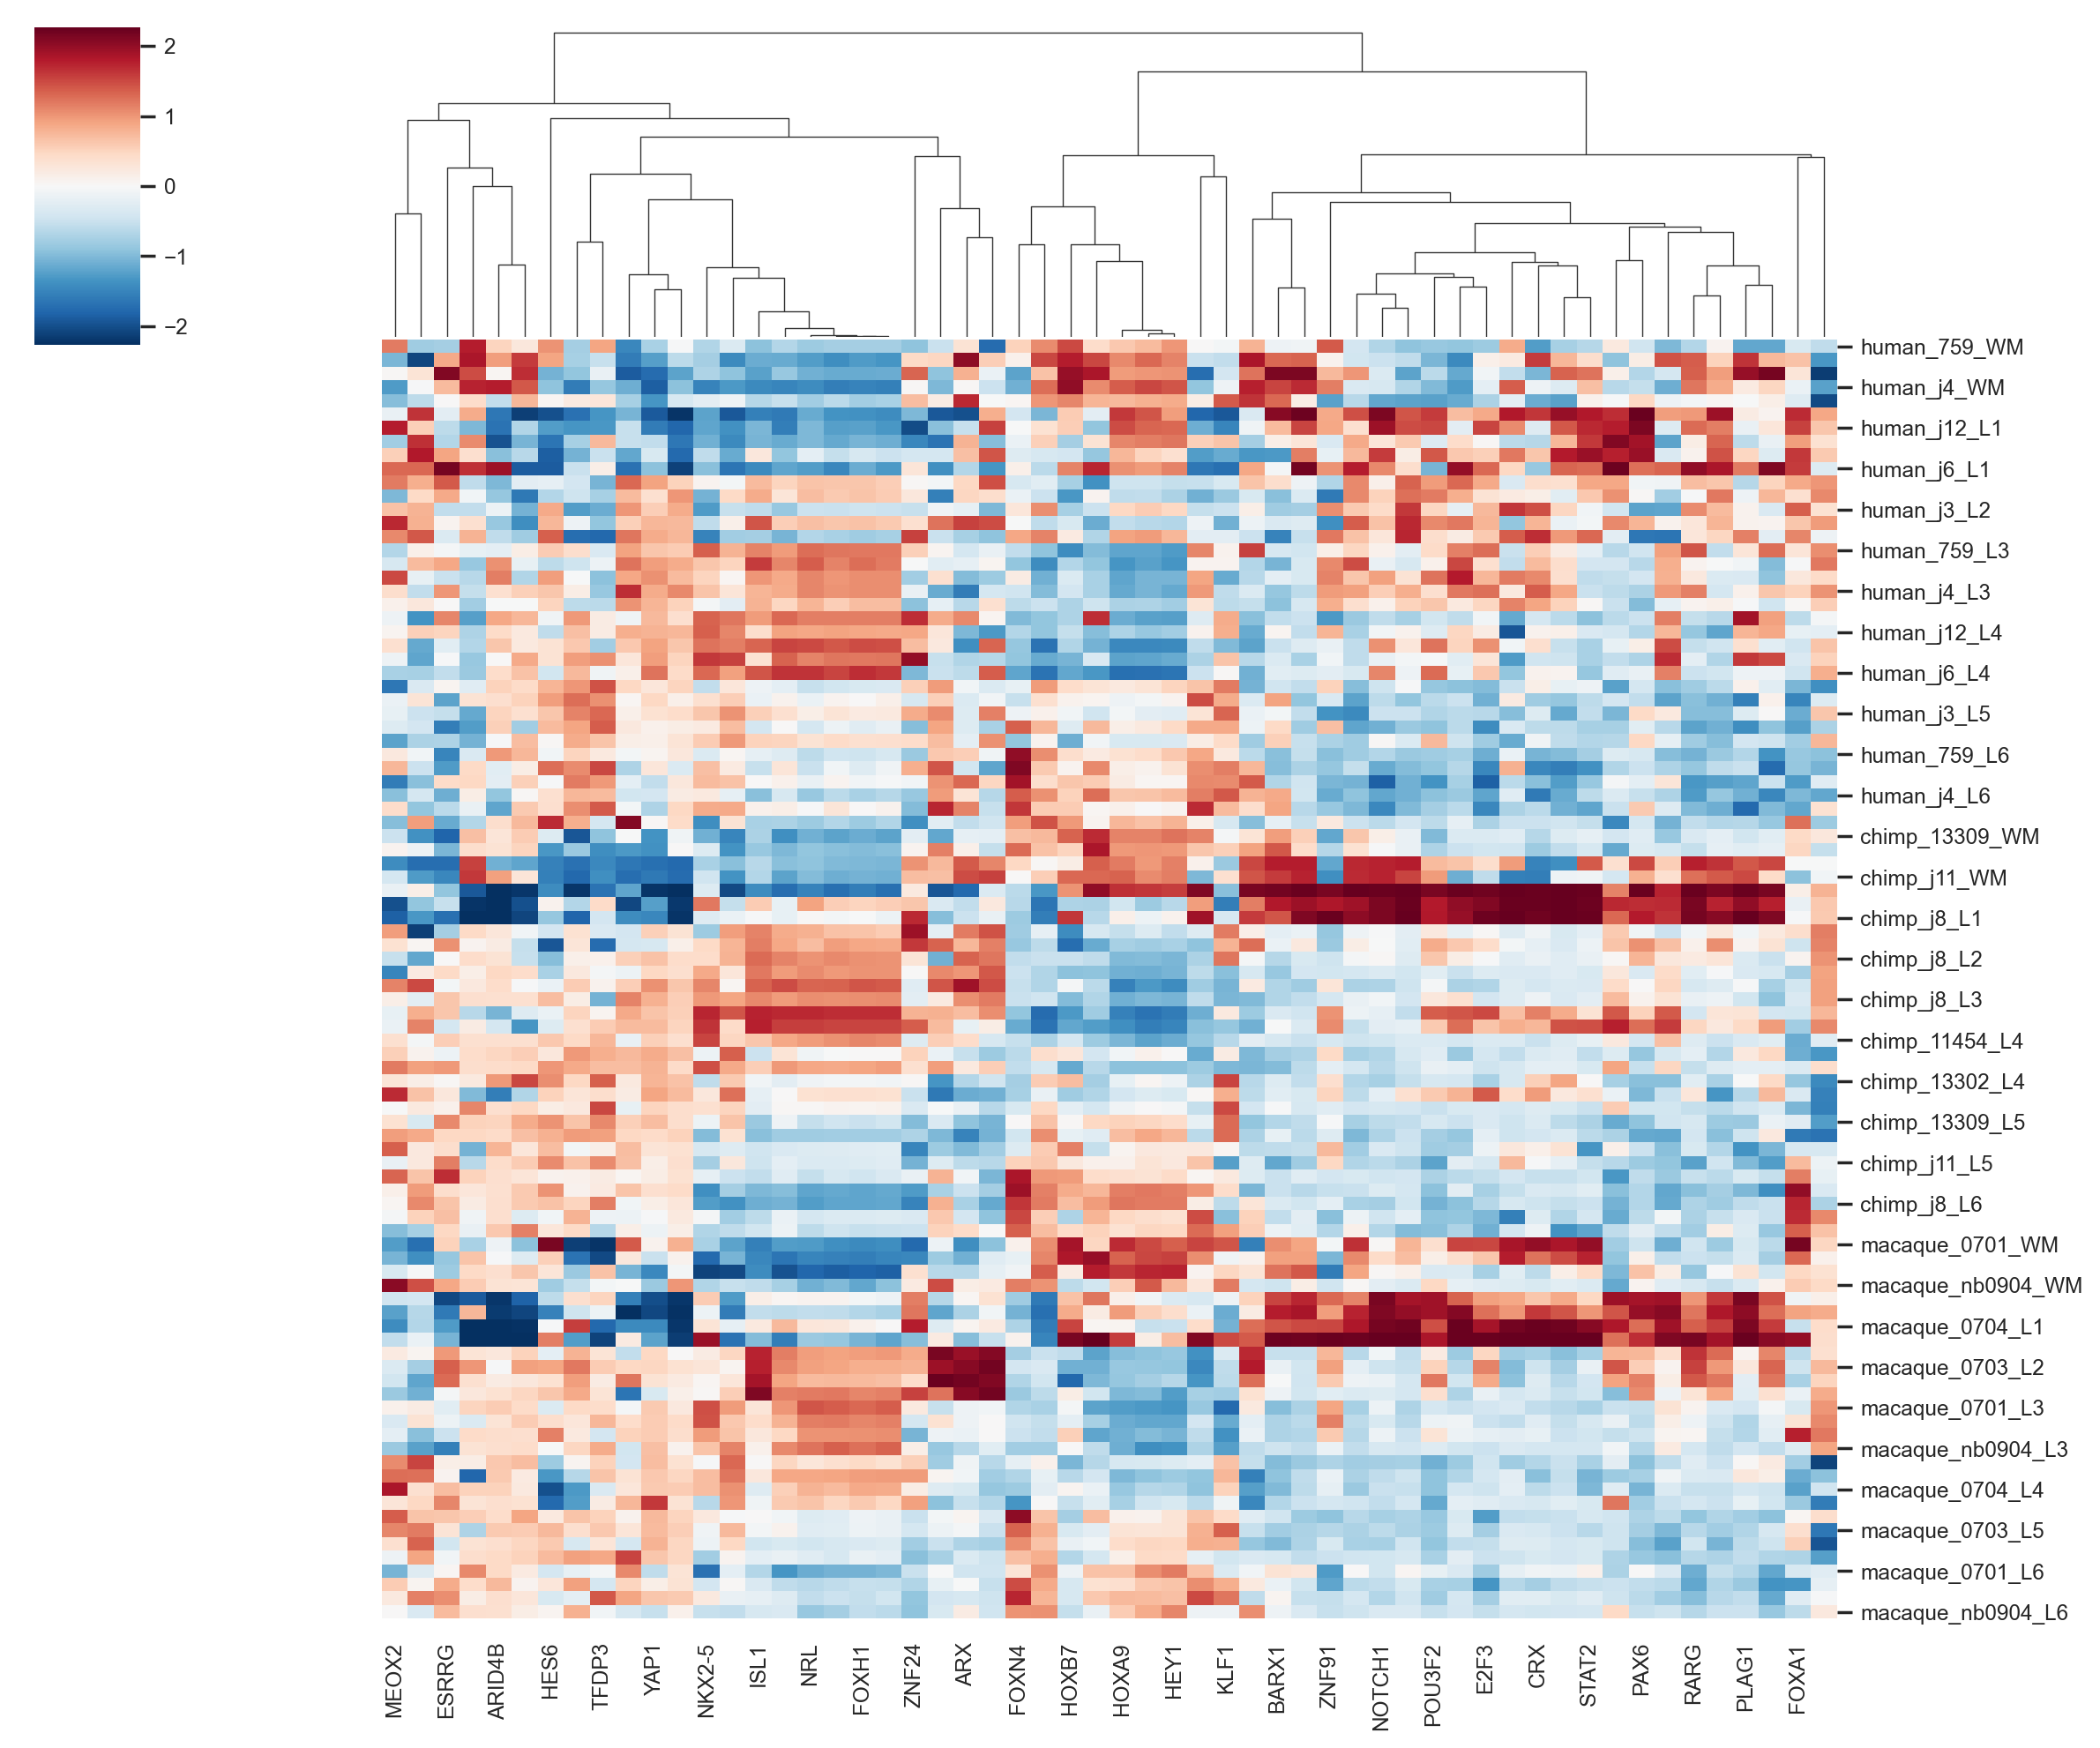

In [100]:
sns.set(font_scale=0.8)
cluster_grid = sns.clustermap(act_df_hs, figsize=(12, 10), cmap="RdBu_r", center=0, metric='cosine', annot_kws={"size": 2}, row_cluster=False)

<Axes: >

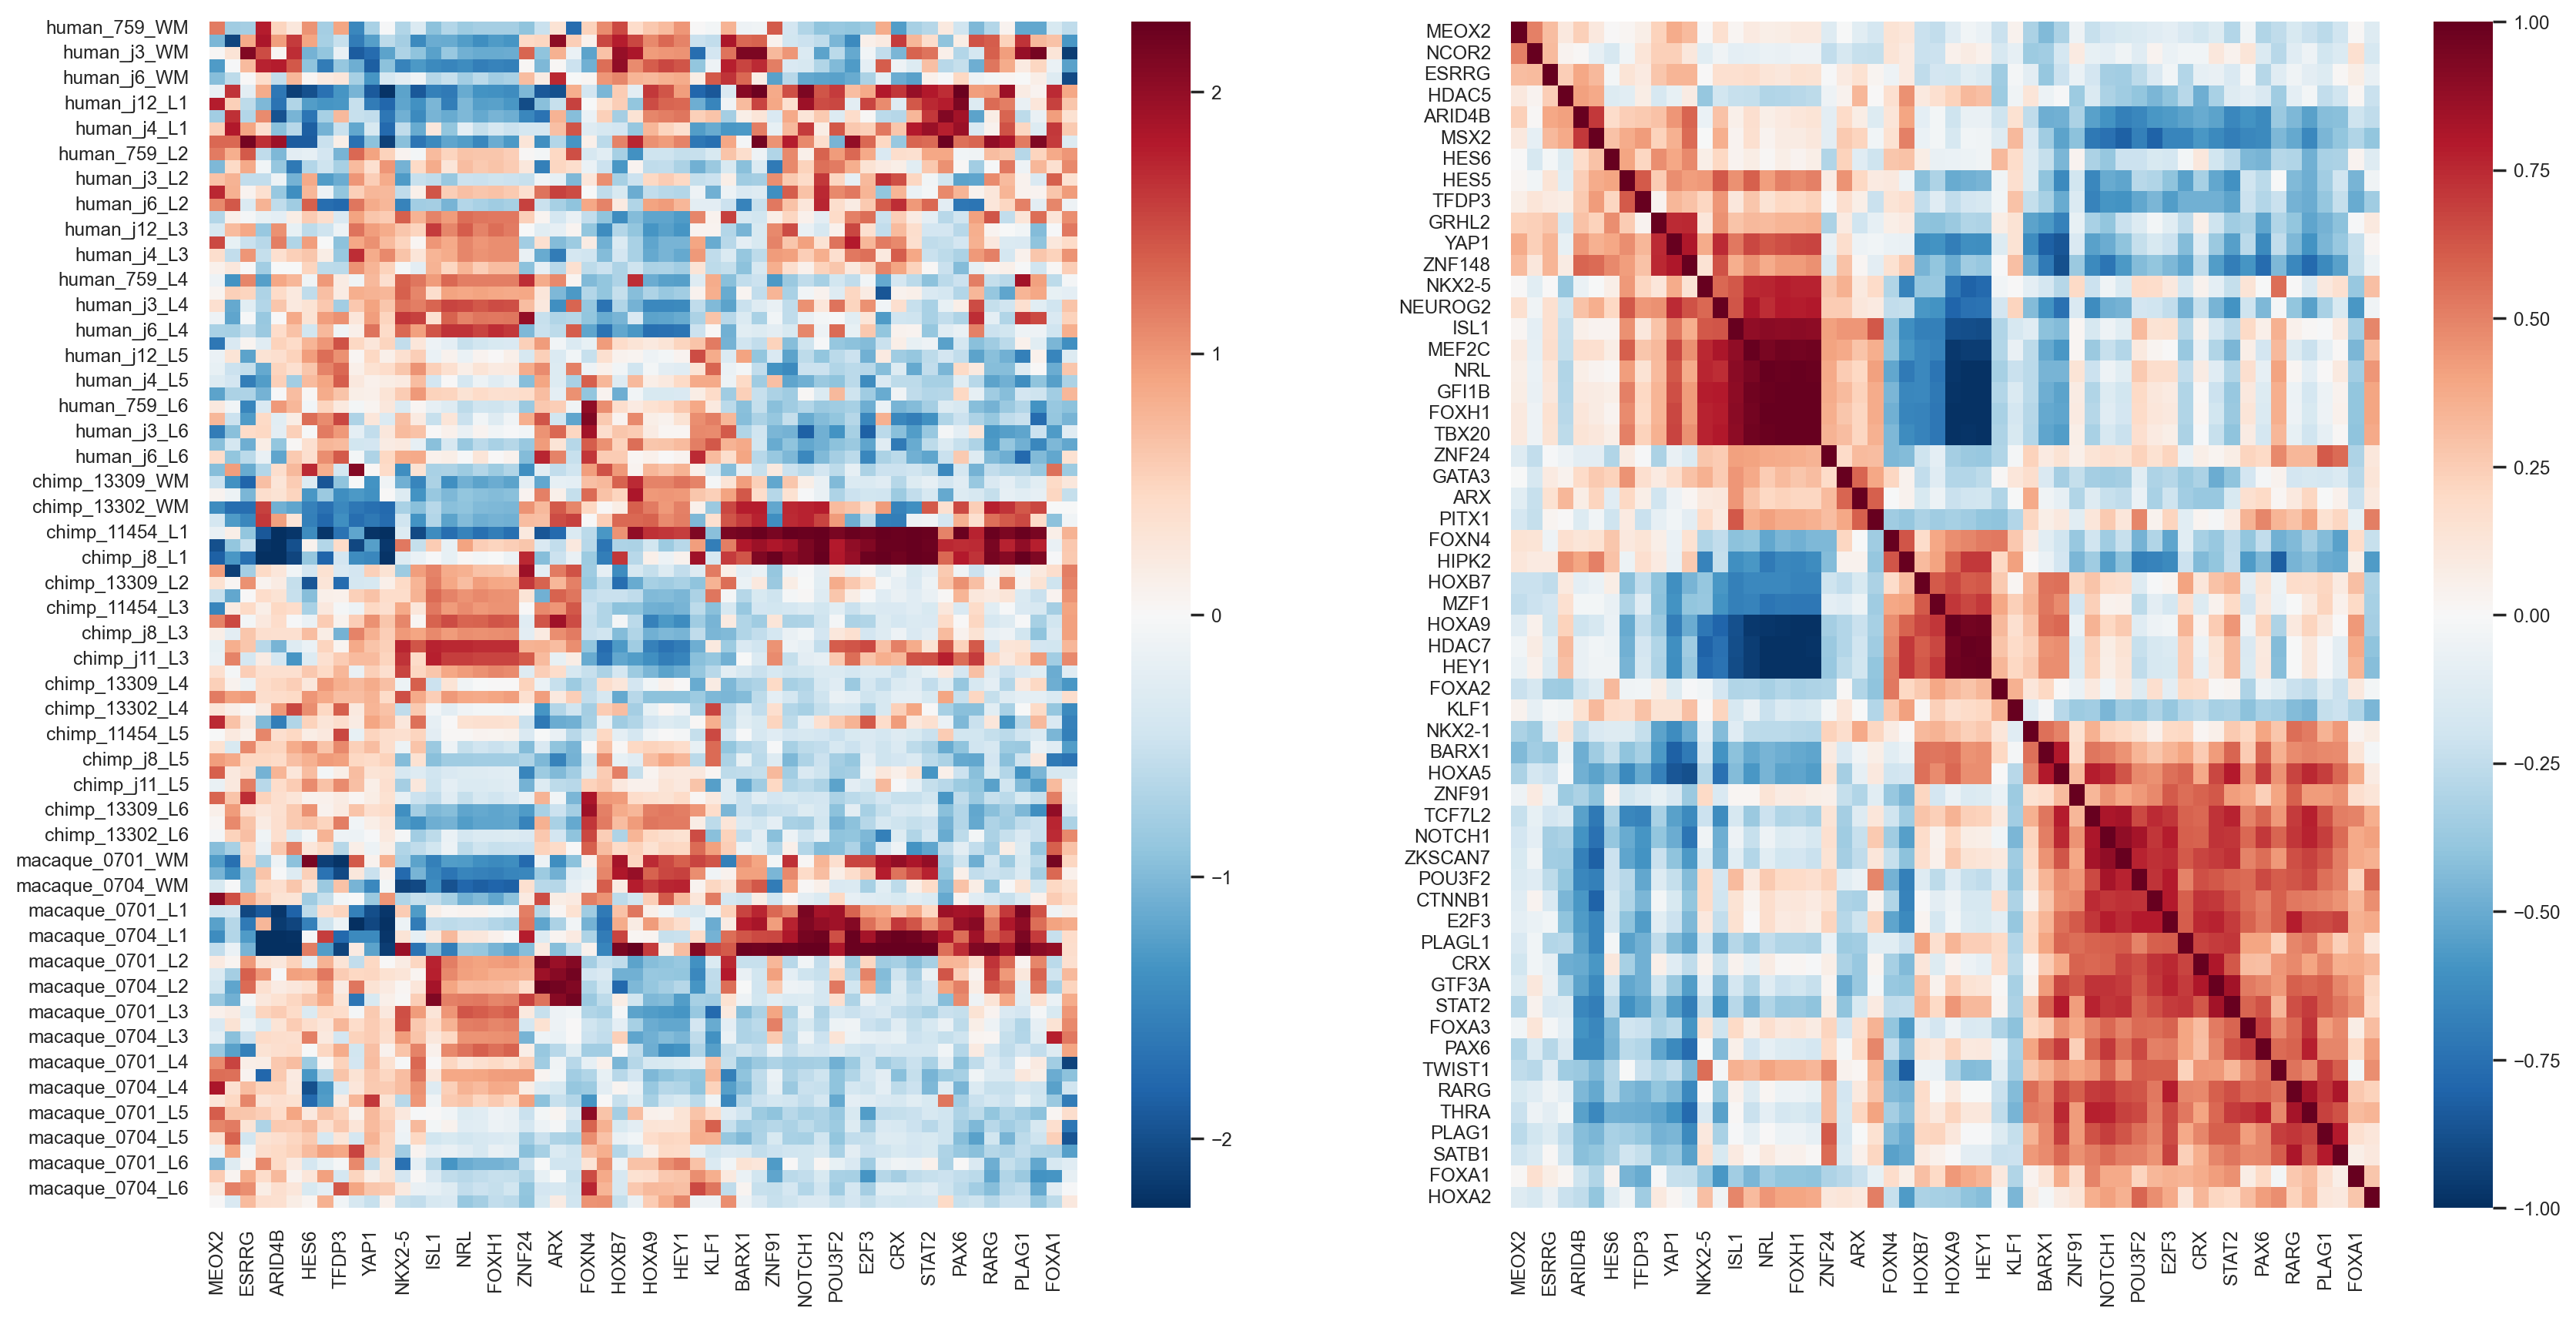

In [101]:
from sklearn.metrics.pairwise import pairwise_kernels
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

gene_order = act_df_hs.columns[cluster_grid.dendrogram_col.reordered_ind]
sns.heatmap(act_df_hs[gene_order], cmap="RdBu_r", center=0, cbar=True, ax=ax[0])

aff_matrix = pairwise_kernels(act_df_hs.T, metric='cosine')
aff_df = pd.DataFrame(aff_matrix, index=act_df_hs.columns, columns=act_df_hs.columns)
sns.heatmap(aff_df.loc[gene_order, gene_order], cmap="RdBu_r", center=0, cbar=True, ax=ax[1], vmin=-1, vmax=1)

In [106]:
collectri[(collectri.source.isin(hs_tf.to_list())) & (collectri.target.isin(hs_genes.to_list()))]

source    target  weight               PMID
2476    NKX2-5      CALR       1           11106640
12878   NKX2-5       ID2       1           17559079
13433    GATA3      CALR       1           17910949
15216    MEF2C      CALR       1  15998798;18765291
24478    HOXA2      PCP4      -1           23671666
24771    HOXA5      LHX2       1           23864708
30937    HOXA9       ID2       1           20565746
32939    TFDP3  MAP1LC3B       1           22482402
33634   CTNNB1      GAD1       1  12782598;15592430
33650   CTNNB1       ID2       1  11572874;12095419
33656   CTNNB1    IGFBP6      -1           14737101
34251   TCF7L2    IGFBP6      -1           14737101
36033    SATB1    IGFBP2       1           17343824
38337     PAX6      LHX2       1           19146846
38562    NCOR2       LPL      -1           10098492
41187  NEUROG2    ZBTB18       1           23395638

In [110]:
act_df_layer = act_df.copy()
act_df_layer['layer'] = acts.obs.loc[act_df.index, 'layer']
act_df_layer['condition'] = acts.obs.loc[act_df.index, 'condition']
act_df_layer.head()

ABL1     AEBP1       AHR      AIRE       AP1     APEX1  \
human_759_WM -0.749606  0.230137 -0.889791  0.970246  0.319226  0.552654   
human_j12_WM  1.536170  2.000469 -0.162203  1.796740  1.644010  0.093659   
human_j3_WM  -0.534454  1.704133  0.236545  1.811229  1.741848  0.847979   
human_j4_WM  -1.245422  1.624155  0.093211  1.832428  1.249996  1.011348   
human_j6_WM  -0.256517  0.228995 -0.782932  0.171968  0.535617  0.510939   

                    AR    ARID1A    ARID1B    ARID3A  ...    ZNF384    ZNF395  \
human_759_WM  0.437370 -0.154164  0.683915  0.083761  ...  0.590895 -1.338258   
human_j12_WM  1.354494 -0.047791 -0.484264  0.894966  ...  2.132667  1.504393   
human_j3_WM  -0.391152  1.191887 -0.095132 -0.827364  ...  1.834796 -0.162700   
human_j4_WM  -0.972936 -0.580825 -0.018855 -0.042578  ...  1.965692  0.435513   
human_j6_WM   0.632999  0.983600  1.037525 -0.731267  ...  0.387605 -1.868216   

                ZNF423    ZNF436    ZNF699     ZNF76   ZNF804A     ZNF91  \
human_759_WM -0.905555  0.321508 -0.076301 -0.584946  0.943144  1.381857   
human_j12_WM  0.535651 -0.991961 -1.040867 -0.766189 -0.851240  0.095794   
human_j3_WM   0.155240 -1.431275 -1.359343 -2.054123  1.040125  0.739174   
human_j4_WM  -0.001741 -0.346639 -1.806538 -2.024143  0.216786  1.156464   
human_j6_WM  -0.899803  1.198570 -0.325130 -1.344908 -0.326775 -1.236033   

              layer  condition  
human_759_WM     WM      human  
human_j12_WM     WM      human  
human_j3_WM      WM      human  
human_j4_WM      WM      human  
human_j6_WM      WM      human  

[5 rows x 725 columns]

In [111]:
layer_mean = act_df_layer.groupby(['condition', 'layer']).mean()
layer_mean.head()

ABL1     AEBP1       AHR      AIRE       AP1     APEX1  \
condition layer                                                               
chimp     L1     0.248219  1.809251  1.168873 -0.238126  2.056308  1.007452   
          L2    -0.110624  0.062393 -0.426090  1.417481 -0.069926 -0.317888   
          L3    -0.234394 -0.214789  0.950933  0.519248 -0.515123 -1.403912   
          L4     0.544183 -0.310593  0.037154 -0.157166 -0.760511 -0.633819   
          L5     0.358453 -0.337201 -0.549535 -0.665194 -0.566168  0.438164   

                       AR    ARID1A    ARID1B    ARID3A  ...    ZNF362  \
condition layer                                          ...             
chimp     L1     1.393722 -0.915689 -0.948257 -1.017197  ...  1.101023   
          L2    -0.683696  1.257393 -0.361151  0.707644  ...  0.210585   
          L3    -0.188612  0.936396 -0.257223  0.398316  ... -0.529280   
          L4    -0.408663 -0.164052  0.064430  0.602986  ... -0.498320   
          L5    -0.759947 -0.683865  0.225771  0.381231  ... -0.499683   

                   ZNF382    ZNF384    ZNF395    ZNF423    ZNF436    ZNF699  \
condition layer                                                               
chimp     L1    -1.654410  1.725042  0.445404 -0.823315  0.920083 -1.244546   
          L2    -0.942357 -0.572618  0.258549  1.086076  0.177842  1.324056   
          L3    -0.250134 -0.673130  0.738893  1.057371 -0.166666  0.775778   
          L4     0.047077 -0.671885  0.301712  0.347076 -0.042296 -0.015797   
          L5     0.529070 -0.492004 -0.299711  0.113328 -0.463169  0.042872   

                    ZNF76   ZNF804A     ZNF91  
condition layer                                
chimp     L1    -0.929516  0.810657  2.074229  
          L2    -0.692986 -1.519404 -0.725420  
          L3    -0.513047  0.054551  0.307727  
          L4     0.166143  0.195083  0.149669  
          L5     0.006130 -0.157253  0.121483  

[5 rows x 723 columns]

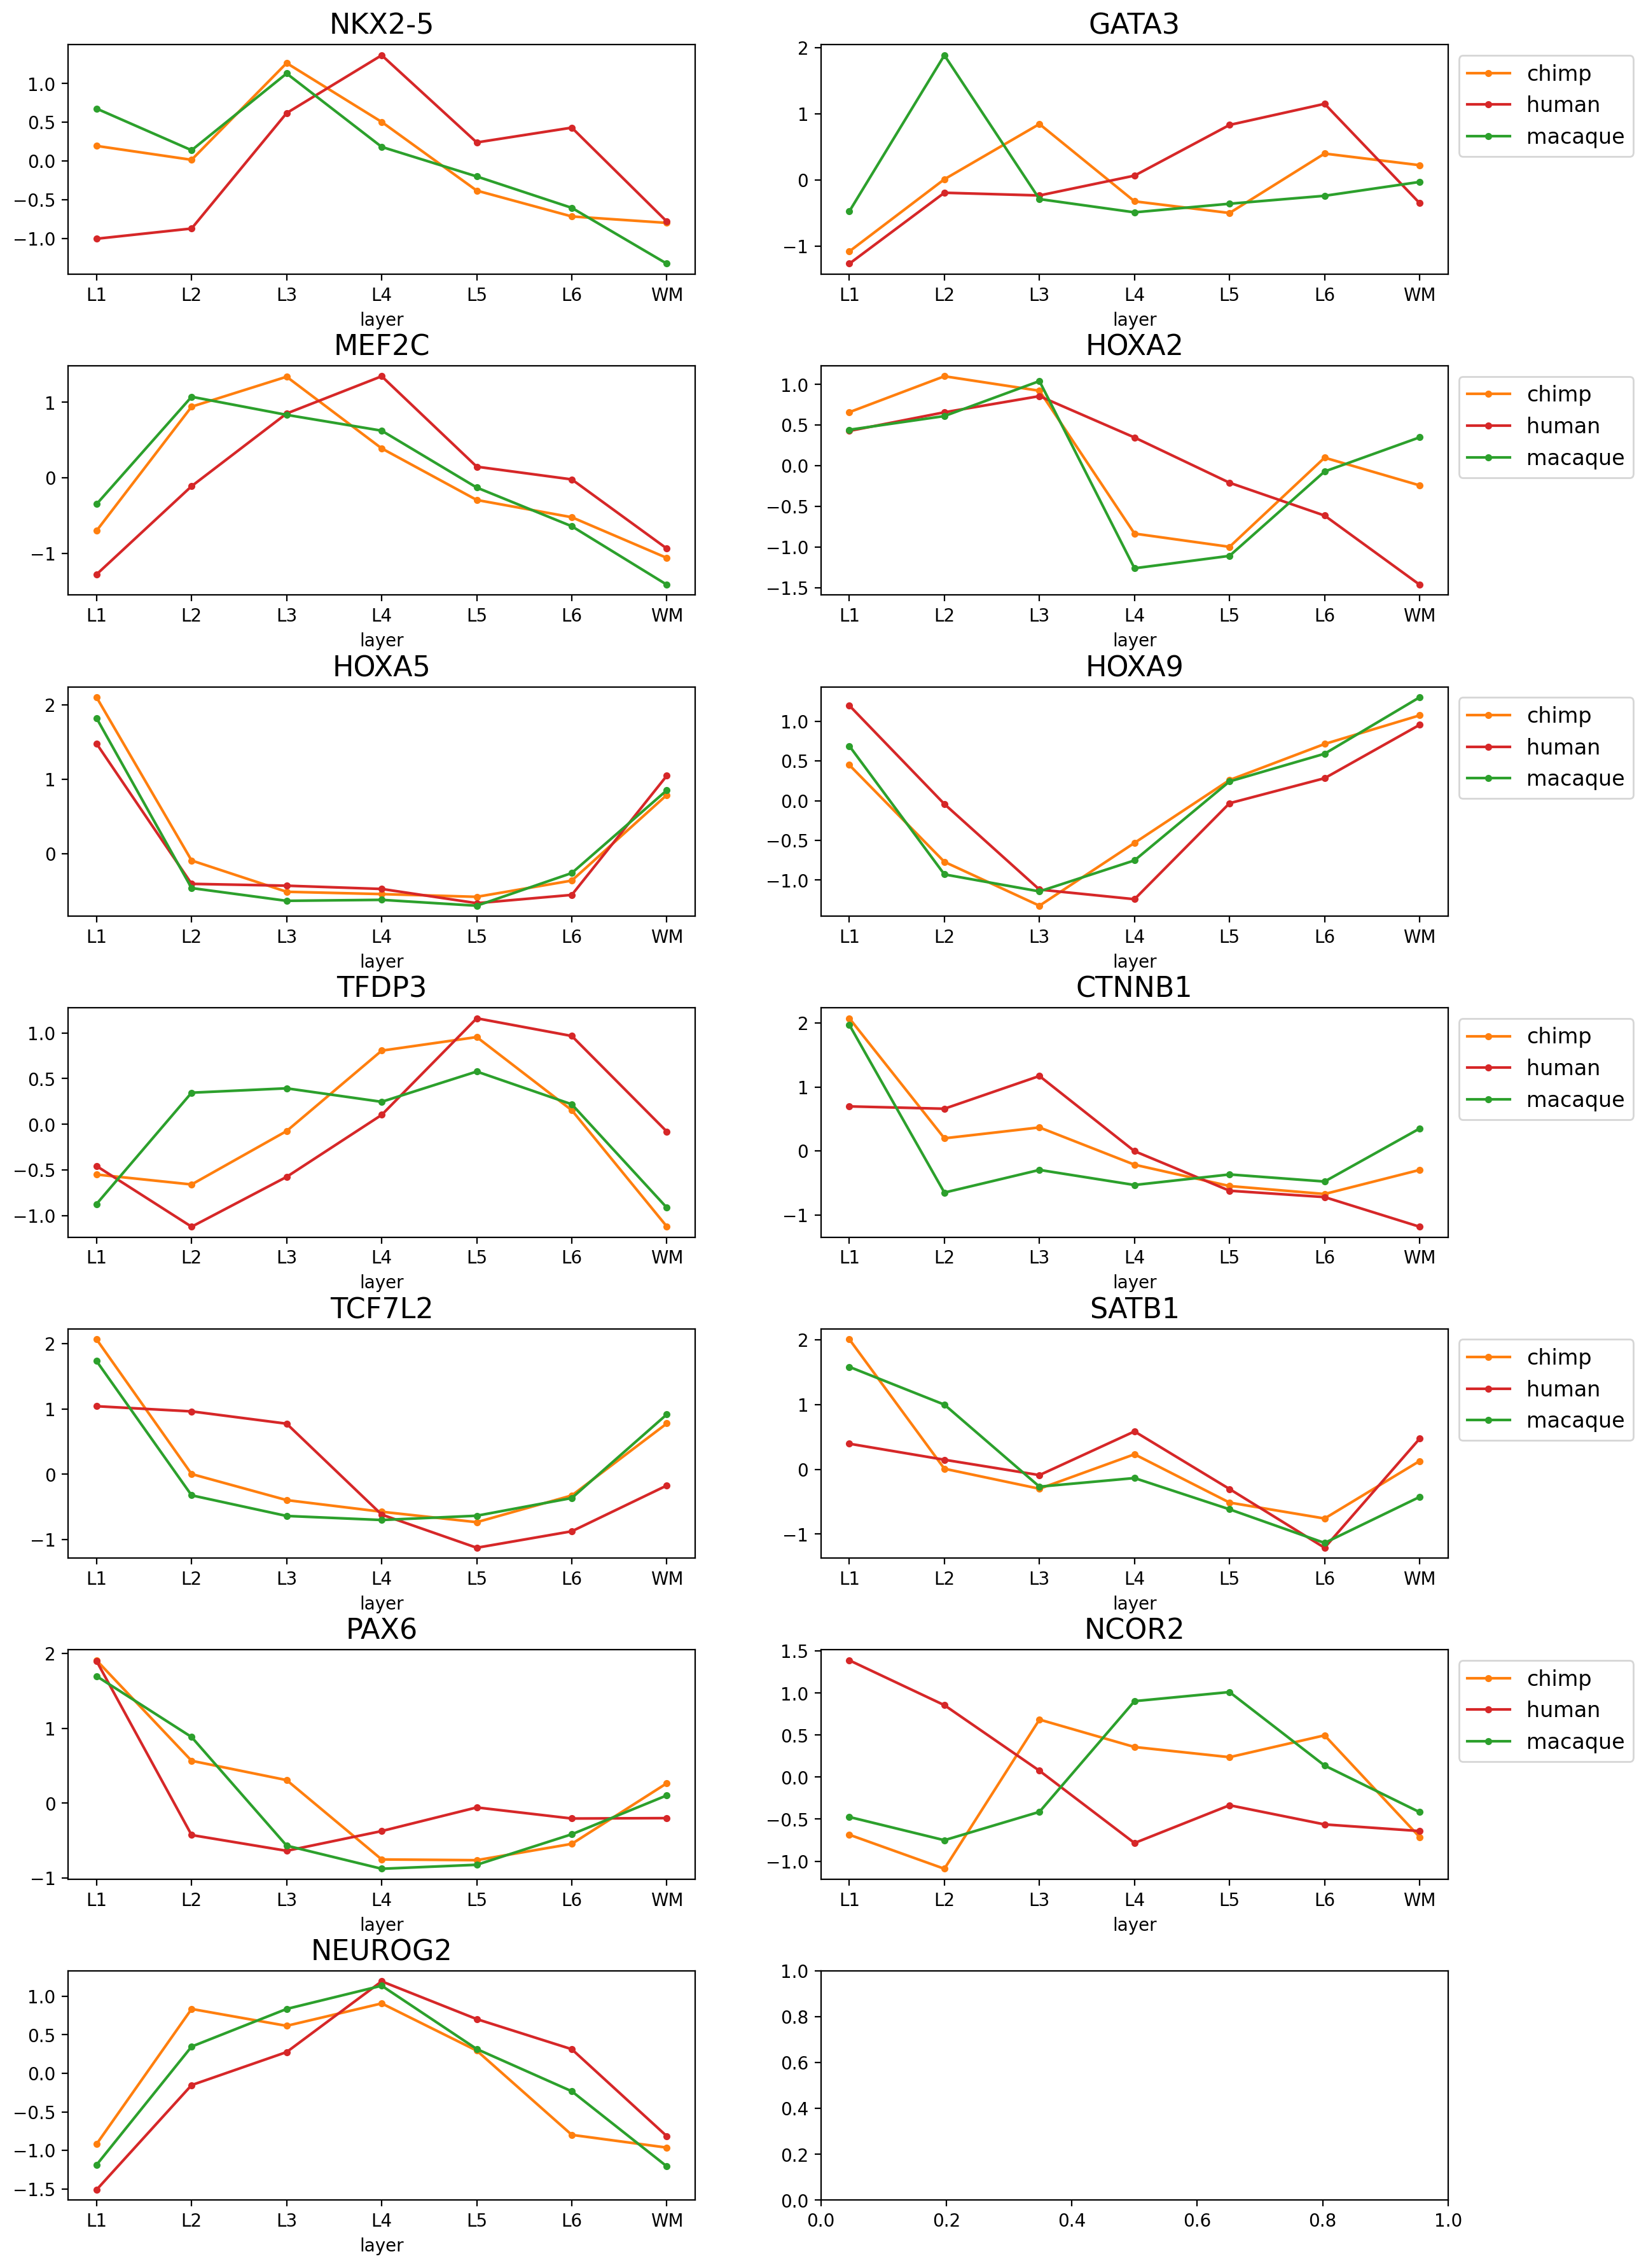

In [117]:
mpl.rcdefaults()
genes = collectri[(collectri.source.isin(hs_tf.to_list())) & (collectri.target.isin(hs_genes.to_list()))].source.unique().tolist()
fig, axes = plt.subplots((len(genes) + 1) // 2, 2,  figsize=(14, 3.5 * len(genes) // 2), gridspec_kw={'hspace': 0.4})
for gene, ax in zip(genes, axes.flatten()):
    (
        layer_mean[gene]
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax, marker='.')
    )
    
    ax.legend(fontsize=10, loc="upper left", bbox_to_anchor=(1, 1), prop={"size":12})
    if genes.index(gene) % 2 == 0:
        ax.get_legend().remove()
    ax.set_title(gene.upper(), fontsize=16)
    ax.grid(False)

In [118]:
grid = np.linspace(1, 7, 400)
conditions = ['human', 'chimp', 'macaque']
cond_colors = ['tab:red', 'tab:orange', 'tab:green']

In [119]:
df_cont = act_df_layer.copy()
df_cont['layer'] = df_cont.layer.map(dict(zip(sorted(df_cont.layer.unique()), range(1, 8)))).astype(int)

In [123]:
from scipy.interpolate import UnivariateSpline

array = np.zeros((grid.size, len(genes)))
df_list = []

for specie in conditions:
    for i, gene in enumerate(genes):
        #fit spline
        subs_index = df_cont[df_cont.condition == specie].index
        targ_dataset = df_cont.loc[subs_index].copy().sort_values(by='layer')
        x = targ_dataset['layer'].values
        y = targ_dataset[gene].values
        spl = UnivariateSpline(x, y, k=3)
        array[:, i] = spl(grid)
    df_specie = pd.DataFrame(array, columns=genes)
    df_specie['condition'] = specie
    df_list.append(df_specie.copy())
df_spline = pd.concat(df_list)

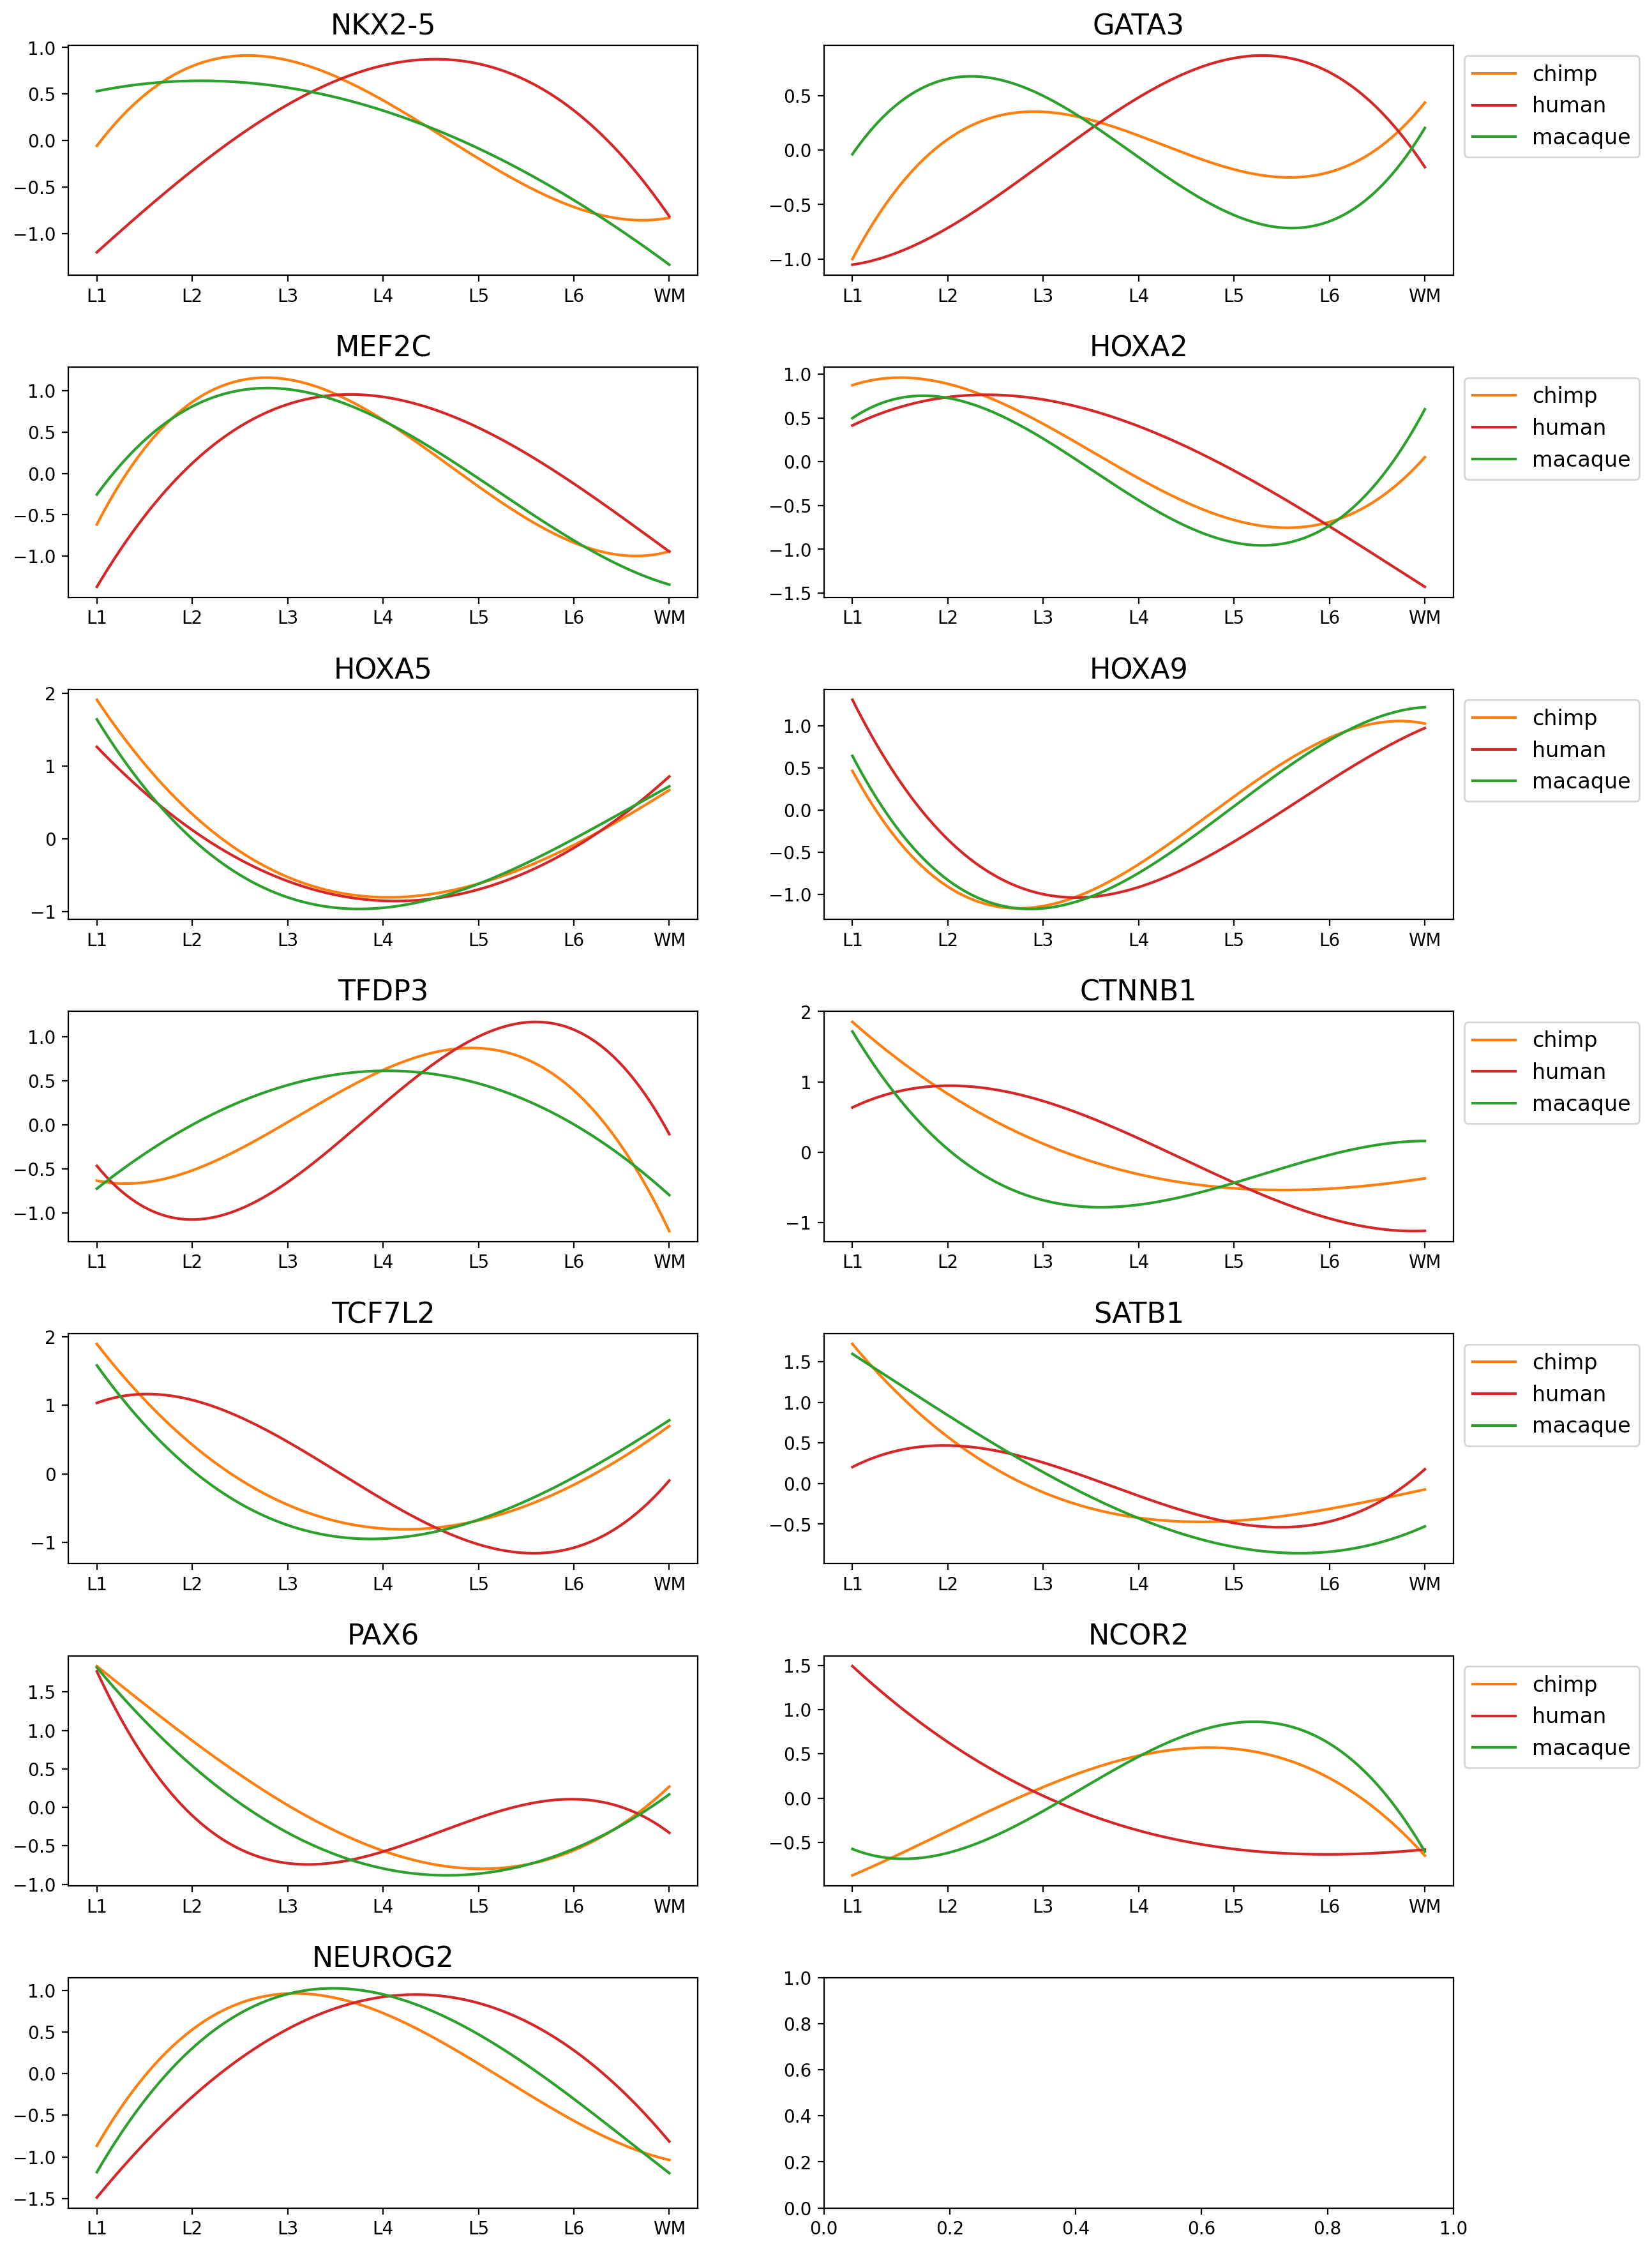

In [127]:
from matplotlib import ticker

mpl.rcdefaults()
fig, axes = plt.subplots((len(genes) + 1) // 2, 2,  figsize=(14, 3.5 * len(genes) // 2), gridspec_kw={'hspace': 0.4})
for gene, ax in zip(genes, axes.flatten()):
    df_cluster_spline = df_spline[[gene, 'condition']]
    df_cluster_spline = df_cluster_spline.pivot(columns='condition', values=gene)
    df_cluster_spline.index = grid
    df_cluster_spline.plot.line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax)

    # plot the dots
    # df_layers = layer_mean[genes].mean(axis=1).reorder_levels(['layer', 'condition']).unstack().loc[layers][conditions]
    # df_layers.index = np.arange(1, 8)
    # ax.set_prop_cycle(color=['tab:red', 'tab:orange', 'tab:green'])
    # ax.plot(df_layers, 'o', alpha=0.7)
    # ax.legend(conditions)
    
    
    ax.legend(fontsize=10, loc="upper left", bbox_to_anchor=(1, 1), prop={"size":12})
    ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(1, 8)))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
    
    if genes.index(gene) % 2 == 0:
        ax.get_legend().remove()
    ax.set_title(gene.upper(), fontsize=16)
    ax.grid(False)
    #ax.hlines(0, xmin=1, xmax=6, colors='gray', linestyles='dashed')

# Approach 5 (ranked lists ULM)

## Load EdgeR results

In [59]:
from statsmodels.stats.multitest import multipletests
import pandas as pd
res_dict = dict()
res_dict['human-chimp'] = pd.read_csv('results/edgeR_human_chimp.csv', index_col=0)
res_dict['human-macaque'] = pd.read_csv('results/edgeR_human_macaque.csv', index_col=0)
res_dict['chimp-macaque'] = pd.read_csv('results/edgeR_chimp_macaque.csv', index_col=0)

for key, df in res_dict.items():
    mult_test = multipletests(df['PValue'], method='fdr_bh')
    df['p_val_adj'] = mult_test[1]

res_dict['human-chimp'].head()

logFC.spline_1.human  logFC.spline_2.human  logFC.spline_3.human  \
A1BG               0.244038              0.286535              0.252427   
AACS              -0.388070             -0.241365             -0.039750   
AADAT             -0.399771             -0.369816             -0.361727   
AAGAB              0.086928              0.361438              0.044400   
AAK1               0.231119              0.421302              0.032839   

         logCPM         F    PValue  p_val_adj  
A1BG   8.937955  1.353039  0.266747   0.847434  
AACS   8.898749  1.925657  0.131096   0.624955  
AADAT  8.822620  0.269978  0.846744   1.000000  
AAGAB  8.837510  0.579746  0.630315   1.000000  
AAK1   8.977608  0.409947  0.746269   1.000000

In [60]:
sign_genes = lambda df: df[df.p_val_adj < 0.05].index
sign_genes_dict = {key:sign_genes(df) for key, df in res_dict.items()}
sign_genes_dict

{'human-chimp': Index(['ACTN2', 'ADGRB2', 'ADGRG1', 'ADGRL1', 'ALCAM', 'AMZ2', 'ANK3', 'AP2S1',
        'APBA1', 'APBA2',
        ...
        'UQCRB', 'UQCRH', 'VAT1L', 'WDR37', 'WLS', 'ZBTB18', 'ZBTB46',
        'ZCCHC17', 'ZMYND8', 'ZNF706'],
       dtype='object', length=224),
 'human-macaque': Index(['AACS', 'AARS1', 'AATK', 'ABAT', 'ABCA2', 'ABCC10', 'ABCC5', 'ABCD3',
        'ABCD4', 'ABHD10',
        ...
        'ZNF483', 'ZNF536', 'ZNF579', 'ZNF706', 'ZNF770', 'ZNF791', 'ZNHIT3',
        'ZRANB2', 'ZYG11B', 'ZYX'],
       dtype='object', length=2141),
 'chimp-macaque': Index(['AARS1', 'AATK', 'ABAT', 'ABCD3', 'ABCD4', 'ABLIM3', 'ABTB1', 'ACAD9',
        'ACHE', 'ACOT7',
        ...
        'YPEL5', 'YWHAB', 'YWHAG', 'ZDHHC22', 'ZDHHC8', 'ZDHHC9', 'ZFAND5',
        'ZMPSTE24', 'ZNF536', 'ZNF655'],
       dtype='object', length=1057)}

Попробуем определить человеко-специфичные гены как $(HC\bigcap HM)\setminus CM$

In [61]:
hs_genes = sign_genes_dict['human-chimp'].intersection(sign_genes_dict['human-macaque']).difference(sign_genes_dict['chimp-macaque'])
hs_genes, hs_genes.size

(Index(['ALCAM', 'AMZ2', 'ASAH1', 'ASAP2', 'ATP1A3', 'CALR', 'CAMLG', 'CD47',
        'CHST10', 'CLSTN1', 'COTL1', 'CX3CL1', 'DLGAP4', 'ECSIT', 'EEF1G',
        'EIF1B', 'EIF3L', 'ERC1', 'ETFB', 'FBXO9', 'GAD1', 'GDE1', 'GNAI1',
        'GPX4', 'ID2', 'IGFBP2', 'IGFBP6', 'IGSF21', 'KIF21B', 'KLHL2', 'LDHB',
        'LHX2', 'LPL', 'MACF1', 'MAP1LC3B', 'MAZ', 'MRPL51', 'NDUFB10',
        'NDUFB7', 'NRXN1', 'NRXN2', 'NUAK1', 'OLA1', 'PCP4', 'PDE1A', 'PES1',
        'PPA1', 'PPP1CC', 'PSMB7', 'PTPRK', 'RBIS', 'RGS2', 'SCN3B', 'SEPTIN6',
        'ST3GAL5', 'SULF2', 'SYNGAP1', 'TCEAL4', 'TMED3', 'TRIR', 'UBE2V1',
        'VAT1L', 'ZBTB18', 'ZBTB46', 'ZNF706'],
       dtype='object'),
 65)

## Perform TF enrichment

In [62]:
np.heaviside([[1, 2, -1, -2, 0], [1, 2, -1, -2, 0]], 0)

array([[1., 1., 0., 0., 0.],
       [1., 1., 0., 0., 0.]])

In [64]:
contrasts = pd.concat([res_dict['human-chimp']['F'].to_frame(), res_dict['human-macaque']['F'].to_frame(), res_dict['chimp-macaque']['F']], axis=1)
contrasts.columns = ['human-chimp', 'human-macaque', 'chimp-macaque']
contrasts = contrasts * np.heaviside(contrasts.values, 0)
mat = contrasts.T
mat

A1BG      AACS     AADAT     AAGAB      AAK1      AAMP  \
human-chimp    1.353039  1.925657  0.269978  0.579746  0.409947  0.615561   
human-macaque  0.195660  5.628289  1.891785  2.713045  0.573586  0.180723   
chimp-macaque  0.589523  3.387220  0.487904  2.444999  0.452643  0.458435   

                   AAR2      AARS1  AASDHPPT      AATF  ...   ZSCAN26  \
human-chimp    1.141759   2.075639  0.566460  0.797640  ...  1.196369   
human-macaque  1.770545  12.132697  2.879655  1.365877  ...  0.477506   
chimp-macaque  1.171924   9.356711  2.080975  0.469885  ...  1.850079   

                 ZSWIM6    ZSWIM7    ZSWIM8      ZUP1    ZWILCH    ZYG11B  \
human-chimp    0.355099  0.128745  0.879447  0.326197  0.682405  0.069960   
human-macaque  0.037304  1.850735  1.126175  0.414321  3.220809  4.308387   
chimp-macaque  0.369749  2.074110  0.651928  0.281421  0.925255  0.051509   

                     ZYX     ZZEF1      ZZZ3  
human-chimp     0.146468  1.282902  0.021137  
human-macaque  12.079743  0.238425  0.422998  
chimp-macaque   0.414162  0.317728  0.317762  

[3 rows x 7790 columns]

In [65]:
# Infer pathway activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri)
tf_acts

AHR      AIRE       AP1     APEX1        AR    ARID4A  \
human-chimp    2.390307 -0.076600 -1.035657 -0.623854  1.963944 -0.451075   
human-macaque  0.738257 -0.569558  1.142210  0.053803  1.133815 -0.750556   
chimp-macaque  2.151481 -0.714098  1.576846 -0.421562  1.318876 -0.706015   

                 ARID4B      ARNT       ARX     ASCL1  ...    ZNF148  \
human-chimp    1.081690  1.617697  2.377858  0.958441  ... -0.303330   
human-macaque  0.965556  0.770252  0.812125  2.690902  ... -0.930297   
chimp-macaque  0.929834  3.517198  1.428106  1.826756  ... -1.692224   

                 ZNF236    ZNF263    ZNF331   ZNF354C    ZNF362    ZNF384  \
human-chimp   -1.002941  1.235074 -0.535050  1.110960  4.673942  0.388876   
human-macaque  0.461305 -0.603954 -1.019603  3.362028  0.863151  3.369370   
chimp-macaque  0.671831 -0.616499 -1.439540  3.495094 -0.256689  3.963156   

                 ZNF436    ZNF699     ZNF91  
human-chimp   -1.163358  0.282544  1.540125  
human-macaque  0.597668  0.690761  2.258115  
chimp-macaque -1.011562  0.205021  1.704940  

[3 rows x 515 columns]

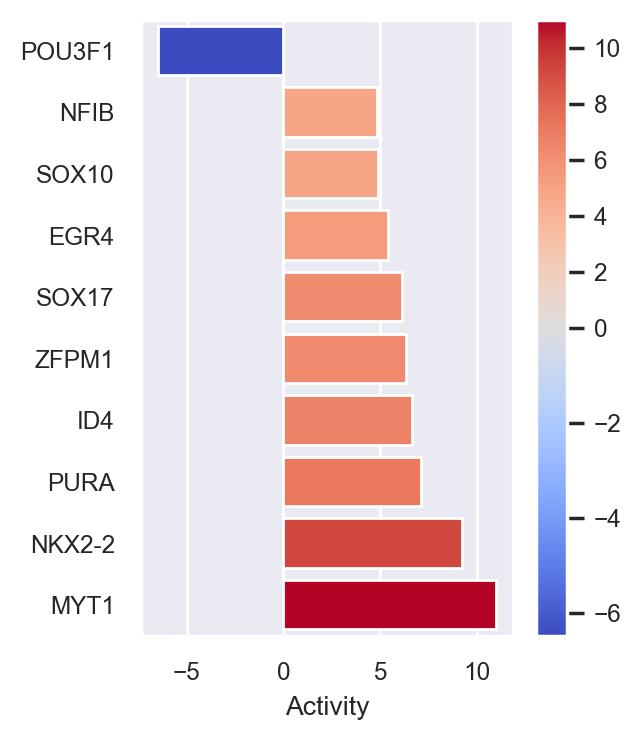

In [93]:
dc.plot_barplot(
    acts=tf_acts,
    contrast='human-chimp',
    top=10,
    vertical=True,
    figsize=(3, 4)
)

In [67]:
tf_pvals_groups = tf_pvals.T
tf_pvals_groups = tf_pvals_groups[(tf_pvals_groups['human-chimp'] < 0.05) & (tf_pvals_groups['human-macaque'] < 0.05) & (tf_pvals_groups['chimp-macaque'] > 0.05)]
hs_tf = tf_pvals_groups.index.to_list()
hs_tf

['ELF4',
 'GATA6',
 'MYT1',
 'NEUROG2',
 'NFIB',
 'NKX2-5',
 'NRF1',
 'PPARD',
 'SP4',
 'TBPL2']

In [68]:
collectri[(collectri.source.isin(hs_tf)) & (collectri.target.isin(hs_genes.to_list()))]

source  target  weight                        PMID
2476    NKX2-5    CALR       1                    11106640
7038      NRF1    CD47       1  14747477;15992771;24250222
12878   NKX2-5     ID2       1                    17559079
14189    GATA6    CALR       1           18303859;18765291
15529    TBPL2     LPL       1                    18974273
17724    PPARD    CALR       1                    20107107
23249     NRF1  ATP1A3       1                    23048038
24307    GATA6  CX3CL1       1                    23583651
25402      SP4  ATP1A3       1                    24219545
31971    PPARD     LPL       1                    10634806
41187  NEUROG2  ZBTB18       1                    23395638

In [69]:
tf_dict = dict()
for tf in hs_tf:
    tf_dict[tf] = collectri[collectri.source == tf].target.unique().tolist()

tf_dict

{'ELF4': ['LYZ',
  'ABCB1',
  'ALDOA',
  'MYOG',
  'PRF1',
  'CXCL8',
  'LTBP1',
  'DEFB4B',
  'LUM',
  'FASLG',
  'POLK',
  'PRB1',
  'MGAT5',
  'MORF4L1',
  'MAP2K2',
  'CDKN2B',
  'LGALS3',
  'MAPK8',
  'CDKN2A',
  'NOS2',
  'AQP2',
  'MAPK1',
  'PDLIM3',
  'SPP1',
  'TCIRG1',
  'AGTR2',
  'TP53',
  'MEFV',
  'GZMB',
  'MAB21L1',
  'CD99',
  'ELF4',
  'PPARG',
  'CARM1',
  'NPM1',
  'CHD7',
  'MDM2',
  'SOD2',
  'NFKB1',
  'IL17A',
  'CCNG1',
  'MBP',
  'CD79A',
  'HBD',
  'MMP9',
  'IFNB1',
  'IFNL3',
  'IFNA2',
  'IFNA8',
  'CSF2',
  'DLX5'],
 'GATA6': ['GATA4',
  'NPPA',
  'TFF1',
  'TFF2',
  'TFF3',
  'MYH11',
  'TNF',
  'VCAM1',
  'HNF4A',
  'SFTPC',
  'WNT7B',
  'VWF',
  'INHA',
  'FABP1',
  'CYP17A1',
  'PLAU',
  'CYP11A1',
  'SULT2A1',
  'LAMA1',
  'ROCK1',
  'MYLK',
  'MYOCD',
  'TAGLN',
  'CYB5A',
  'DAB2',
  'LMCD1',
  'KRAS',
  'HLA-E',
  'SEMA3C',
  'WNT2',
  'BMP4',
  'DKK1',
  'DPPA4',
  'LEFTY2',
  'THY1',
  'ABCG8',
  'NANOG',
  'CLMP',
  'ACTG2',
  'ACTA2',
  'TNC'

In [70]:
collectri.loc[collectri.source.isin(hs_tf), ['source', 'weight']].groupby('source').value_counts()

source   weight
ELF4      1        47
         -1         4
GATA6     1        81
         -1         6
MYT1      1         8
         -1         1
NEUROG2   1        19
         -1         7
NFIB      1        18
         -1         8
NKX2-5    1        69
         -1         5
NRF1      1        87
         -1         4
PPARD     1        76
         -1        24
SP4       1        49
TBPL2     1        10
Name: count, dtype: int64

In [81]:
y = mat.loc['human-chimp', mat.columns.intersection(tf_dict['NFIB'])].values
x = collectri[collectri.source == 'NFIB'].set_index('target').loc[mat.columns.intersection(tf_dict['NFIB'])].weight.values

data = pd.DataFrame([x, y], index=['x', 'y']).T
data.head()


x         y
0 -1.0  1.670712
1  1.0 -0.000000
2  1.0  6.262428
3  1.0  0.563398
4 -1.0  3.038965

In [82]:
tf_acts['NFIB']

human-chimp      4.866404
human-macaque    2.330279
chimp-macaque    1.739297
Name: NFIB, dtype: float32

<Axes: >

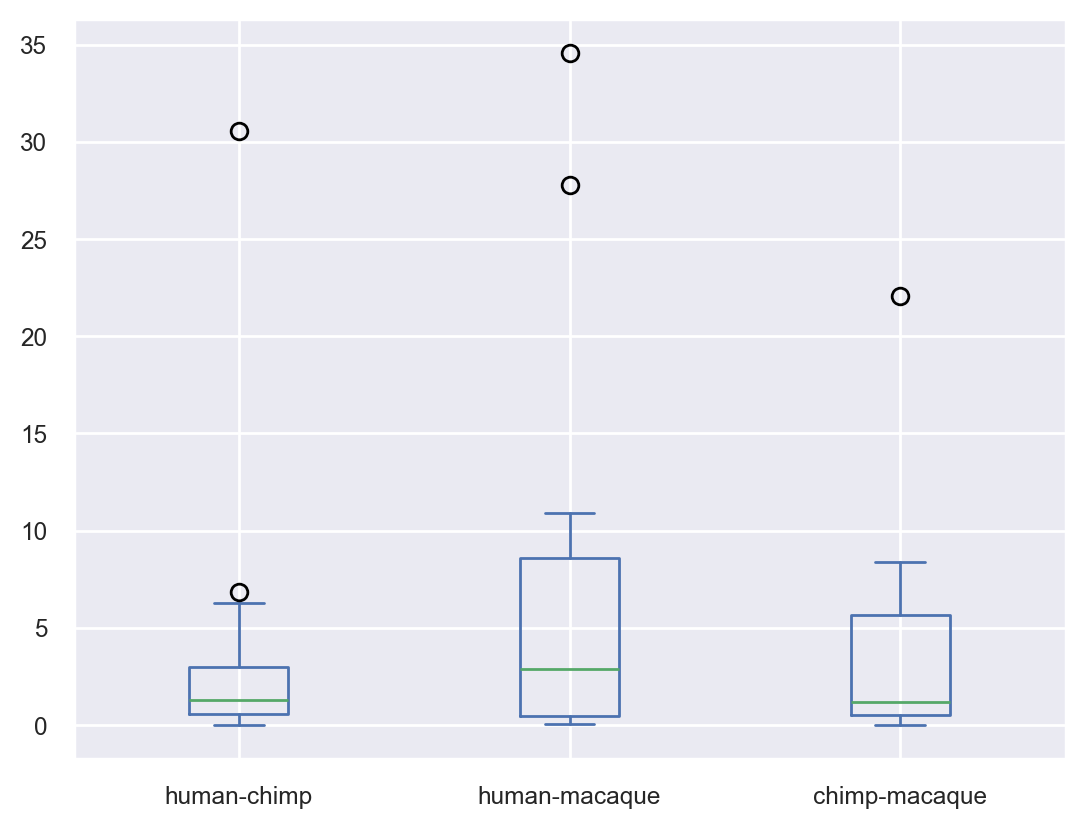

In [92]:
mat[mat.columns.intersection(tf_dict['NFIB'])].T.plot.box()

In [ ]:
tf_acts, tf_pvals

In [85]:
from statsmodels.formula.api import ols

model = ols(formula='y ~ x', data=data)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                 -0.052
Method:                 Least Squares   F-statistic:                    0.3064
Date:                Wed, 24 Jul 2024   Prob (F-statistic):              0.589
Time:                        20:44:02   Log-Likelihood:                -51.112
No. Observations:                  15   AIC:                             106.2
Df Residuals:                      13   BIC:                             107.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3554      2.291      1.465      0.1

c:\projects\spatialMPFC\venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  res = hypotest_fun_out(*samples, **kwds)


NameError: name 'pd' is not defined

array([-1,  1, -1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1])

In [ ]:
mat['NRF1']

KeyError: 'NRF1'

In [ ]:
set(
    ['ARID4B', 'ARX', 'BARX1', 'CRX', 'CTNNB1', 'E2F3', 'ESRRG', 'FOXA1',
        'FOXA2', 'FOXA3', 'FOXH1', 'FOXN4', 'GATA3', 'GFI1B', 'GRHL2', 'GTF3A',
        'HDAC5', 'HDAC7', 'HES5', 'HES6', 'HEY1', 'HIPK2', 'HOXA2', 'HOXA5',
        'HOXA9', 'HOXB7', 'ISL1', 'KLF1', 'MEF2C', 'MEOX2', 'MSX2', 'MZF1',
        'NCOR2', 'NEUROG2', 'NKX2-1', 'NKX2-5', 'NOTCH1', 'NRL', 'PAX6',
        'PITX1', 'PLAG1', 'PLAGL1', 'POU3F2', 'RARG', 'SATB1', 'STAT2', 'TBX20',
        'TCF7L2', 'TFDP3', 'THRA', 'TWIST1', 'YAP1', 'ZKSCAN7', 'ZNF148',
        'ZNF24', 'ZNF91']
).intersection(hs_tf)

{'NEUROG2', 'NKX2-5'}

# Approach 6 (GSEA)

## Load EdgeR results

In [148]:
tf_dict_all = dict()

for tf in collectri.source.unique().tolist():
    tf_dict_all[tf] = collectri[collectri.source == tf].target.unique().tolist()
    # positive_list = collectri[(collectri.source == tf) & (collectri.weight > 0)].target.unique().tolist()
    # negative_list = collectri[(collectri.source == tf) & (collectri.weight < 0)].target.unique().tolist()
    # if positive_list:
    #     tf_dict_all[f'{tf}_positive'] = positive_list
    # if negative_list:
    #     tf_dict_all[f'{tf}_negative'] = negative_list

In [25]:
from statsmodels.stats.multitest import multipletests
import pandas as pd
res_dict = dict()
res_dict['human-chimp'] = pd.read_csv('results/edgeR_human_chimp.csv', index_col=0)
res_dict['human-macaque'] = pd.read_csv('results/edgeR_human_macaque.csv', index_col=0)
res_dict['chimp-macaque'] = pd.read_csv('results/edgeR_chimp_macaque.csv', index_col=0)

for key, df in res_dict.items():
    mult_test = multipletests(df['PValue'], method='fdr_bh')
    df['p_val_adj'] = mult_test[1]

res_dict['human-chimp'].head()

logFC.spline_1.human  logFC.spline_2.human  logFC.spline_3.human  \
A1BG               0.244038              0.286535              0.252427   
AACS              -0.388070             -0.241365             -0.039750   
AADAT             -0.399771             -0.369816             -0.361727   
AAGAB              0.086928              0.361438              0.044400   
AAK1               0.231119              0.421302              0.032839   

         logCPM         F    PValue  p_val_adj  
A1BG   8.937955  1.353039  0.266747   0.847434  
AACS   8.898749  1.925657  0.131096   0.624955  
AADAT  8.822620  0.269978  0.846744   1.000000  
AAGAB  8.837510  0.579746  0.630315   1.000000  
AAK1   8.977608  0.409947  0.746269   1.000000

In [ ]:
sign_genes = lambda df: df[df.p_val_adj < 0.05].index
sign_genes_dict = {key:sign_genes(df) for key, df in res_dict.items()}
sign_genes_dict

{'human-chimp': Index(['ACTN2', 'ADGRB2', 'ADGRG1', 'ADGRL1', 'ALCAM', 'AMZ2', 'ANK3', 'AP2S1',
        'APBA1', 'APBA2',
        ...
        'UQCRB', 'UQCRH', 'VAT1L', 'WDR37', 'WLS', 'ZBTB18', 'ZBTB46',
        'ZCCHC17', 'ZMYND8', 'ZNF706'],
       dtype='object', length=224),
 'human-macaque': Index(['AACS', 'AARS1', 'AATK', 'ABAT', 'ABCA2', 'ABCC10', 'ABCC5', 'ABCD3',
        'ABCD4', 'ABHD10',
        ...
        'ZNF483', 'ZNF536', 'ZNF579', 'ZNF706', 'ZNF770', 'ZNF791', 'ZNHIT3',
        'ZRANB2', 'ZYG11B', 'ZYX'],
       dtype='object', length=2141),
 'chimp-macaque': Index(['AARS1', 'AATK', 'ABAT', 'ABCD3', 'ABCD4', 'ABLIM3', 'ABTB1', 'ACAD9',
        'ACHE', 'ACOT7',
        ...
        'YPEL5', 'YWHAB', 'YWHAG', 'ZDHHC22', 'ZDHHC8', 'ZDHHC9', 'ZFAND5',
        'ZMPSTE24', 'ZNF536', 'ZNF655'],
       dtype='object', length=1057)}

Попробуем определить человеко-специфичные гены как $(HC\bigcap HM)\setminus CM$

In [ ]:
hs_genes = sign_genes_dict['human-chimp'].intersection(sign_genes_dict['human-macaque']).difference(sign_genes_dict['chimp-macaque'])
hs_genes, hs_genes.size

(Index(['ALCAM', 'AMZ2', 'ASAH1', 'ASAP2', 'ATP1A3', 'CALR', 'CAMLG', 'CD47',
        'CHST10', 'CLSTN1', 'COTL1', 'CX3CL1', 'DLGAP4', 'ECSIT', 'EEF1G',
        'EIF1B', 'EIF3L', 'ERC1', 'ETFB', 'FBXO9', 'GAD1', 'GDE1', 'GNAI1',
        'GPX4', 'ID2', 'IGFBP2', 'IGFBP6', 'IGSF21', 'KIF21B', 'KLHL2', 'LDHB',
        'LHX2', 'LPL', 'MACF1', 'MAP1LC3B', 'MAZ', 'MRPL51', 'NDUFB10',
        'NDUFB7', 'NRXN1', 'NRXN2', 'NUAK1', 'OLA1', 'PCP4', 'PDE1A', 'PES1',
        'PPA1', 'PPP1CC', 'PSMB7', 'PTPRK', 'RBIS', 'RGS2', 'SCN3B', 'SEPTIN6',
        'ST3GAL5', 'SULF2', 'SYNGAP1', 'TCEAL4', 'TMED3', 'TRIR', 'UBE2V1',
        'VAT1L', 'ZBTB18', 'ZBTB46', 'ZNF706'],
       dtype='object'),
 65)

## Perform TF enrichment

In [155]:
enrich_res_dict = dict()

In [149]:
df_res = res_dict['human-chimp'][['F']].copy()
df_res.F = df_res.F * np.heaviside(df_res.F.values, 0)

In [231]:
import gseapy

for key in res_dict.keys():
    df_res = res_dict[key][['F']].copy()
    df_res.F = df_res.F * np.heaviside(df_res.F.values, 0)
    df_res.sort_values(by='F', inplace=True, ascending=False)

    pre_res = gseapy.prerank(rnk=df_res, # or rnk = rnk,
                        gene_sets=tf_dict_all,
                        threads=4,
                        min_size=5,
                        max_size=100000,
                        permutation_num=1000, # reduce number to speed up testing
                        outdir=None, # don't write to disk
                        seed=4,
                        verbose=True, # see what's going on behind the scenes
                        weight=0.75
                        )

    enrich_res_dict[key] = pre_res.res2d

2024-07-25 23:16:37,757 [WARNING] Duplicated values found in preranked stats: 0.17% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-25 23:16:37,759 [INFO] Parsing data files for GSEA.............................
2024-07-25 23:16:37,768 [INFO] 0671 gene_sets have been filtered out when max_size=100000 and min_size=5
2024-07-25 23:16:37,769 [INFO] 0515 gene_sets used for further statistical testing.....


2024-07-25 23:16:37,770 [INFO] Start to run GSEA...Might take a while..................
2024-07-25 23:16:44,530 [INFO] Congratulations. GSEApy runs successfully................

2024-07-25 23:16:44,572 [WARNING] Duplicated values found in preranked stats: 0.08% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-25 23:16:44,572 [INFO] Parsing data files for GSEA.............................
2024-07-25 23:16:44,580 [INFO] 0671 gene_sets have been filtered out when max_size=100000 and min_size=5
2024-07-25 23:16:44,582 [INFO] 0515 gene_sets used for further statistical testing.....
2024-07-25 23:16:44,582 [INFO] Start to run GSEA...Might take a while..................
2024-07-25 23:16:51,166 [INFO] Congratulations. GSEApy runs successfully................

2024-07-25 23:16:51,233 [WARNING] Duplicated values found in preranked stats: 0.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-25 23

In [232]:
sign_tf = lambda df, p_tresh: df[(df['NOM p-val'] < p_tresh) & (df['ES'] > 0)].index
sign_tf_dict = {key:sign_tf(df.set_index('Term'), 0.01) for key, df in enrich_res_dict.items()}
sign_tf_dict

{'human-chimp': Index(['NKX2-2', 'GFI1', 'RFX1', 'EGR2', 'MYT1', 'POU3F1', 'IRF9', 'EGR4',
        'NFIB', 'KLF9', 'SOX17', 'ZFPM1', 'SMARCA1', 'MAF', 'DLX1', 'NKX2-5',
        'MAFB', 'EWSR1', 'GLI1', 'GATA3', 'CREB1', 'SP1'],
       dtype='object', name='Term'),
 'human-macaque': Index(['TBX5', 'NR2F1', 'MEF2C', 'NFIB', 'POU3F1', 'CEBPD', 'HEY2', 'TBPL2',
        'NR2E1', 'BCL11A', 'MYT1', 'MBD1', 'ASCL1', 'NKX2-2', 'NEUROD1',
        'POU3F2', 'GATA6', 'SREBF1', 'REST', 'NRF1', 'RXRA', 'CEBPA', 'CEBPG',
        'WT1', 'EGR1', 'YY1', 'HNF4A', 'FOXO1', 'SP3', 'HIF1A', 'JUN', 'SP1',
        'NFKB'],
       dtype='object', name='Term'),
 'chimp-macaque': Index(['TFAP2B', 'SOX2', 'TSC22D1', 'KCNIP3', 'HSF4', 'ID4', 'POU3F2', 'LYL1',
        'FOSB', 'HSF2', 'BCL11A', 'ZGLP1', 'HOXC6', 'TBX3', 'SOX17', 'ARNT',
        'REST', 'GCM1', 'MYF5', 'PAX3', 'CTBP2', 'MECP2', 'GLI1', 'ATF5',
        'HMGA1', 'NFIC', 'LEF1', 'PGR', 'EP300', 'TFAP2A', 'MEF2A', 'KLF4',
        'CEBPA', 'USF1', 'TCF3',

In [249]:
sign_tf = lambda df, p_tresh: df[(df['FDR q-val'] < p_tresh) & (df['ES'] > 0)].index
sign_tf_dict = {key:sign_tf(df.set_index('Term'), 0.25) for key, df in enrich_res_dict.items()}
sign_tf_dict['chimp-macaque'] = sign_tf(enrich_res_dict['chimp-macaque'].set_index('Term'), 0.2)
sign_tf_dict

{'human-chimp': Index(['NKX2-2', 'GFI1', 'RFX1', 'EGR2', 'MYT1', 'POU3F1', 'IRF9', 'EGR4',
        'NFIB', 'KLF9', 'SOX17', 'ZFPM1', 'HLX', 'SMARCA1', 'MAF', 'DLX1',
        'TBX5', 'ZFPM2'],
       dtype='object', name='Term'),
 'human-macaque': Index(['NR2F1', 'MEF2C', 'NFIB', 'POU3F1', 'CEBPD', 'HEY2', 'TBPL2', 'NR2E1',
        'BCL11A', 'MYT1', 'MBD1', 'POU2F2', 'ASCL1', 'PKNOX1', 'ZNF384',
        'MLXIPL', 'NEUROD1', 'POU3F2'],
       dtype='object', name='Term'),
 'chimp-macaque': Index(['TFAP2B', 'SOX2', 'TSC22D1', 'KCNIP3', 'HSF4', 'ID4', 'POU3F2', 'LYL1',
        'FOSB', 'HSF2', 'BCL11A', 'ZGLP1', 'HOXC6', 'TBX3', 'SOX17', 'ARNT',
        'REST', 'HESX1', 'GCM1', 'MYF5', 'PAX3', 'CTBP2', 'NR2E1', 'TBPL2',
        'TGFB1I1', 'HIPK2', 'MECP2', 'RXRB', 'GLI1', 'POU2F2', 'ZFP42', 'SOX10',
        'ATF5', 'ZBTB18', 'HMGA1', 'NFIC', 'MAFB', 'MZF1', 'LEF1', 'PAWR',
        'MAFA', 'ZBTB17', 'MYBL1', 'PLAGL1', 'TBX2', 'HOXA1', 'HEY2', 'DLX5',
        'PGR', 'NFIA', 'HBP1', 'EP300', '

In [250]:
hs_tf = sign_tf_dict['human-chimp'].intersection(sign_tf_dict['human-macaque']).difference(sign_tf_dict['chimp-macaque'])
hs_tf, hs_tf.size

(Index(['MYT1', 'NFIB', 'POU3F1'], dtype='object', name='Term'), 3)

In [251]:
collectri[(collectri.source.isin(hs_tf)) & (collectri.target.isin(hs_genes.to_list()))]

Empty DataFrame
Columns: [source, target, weight, PMID]
Index: []

# Approach 7 (ChEA3)

In [27]:
import gseapy

background_genes = res_dict['human-chimp'].index.tolist()
len(background_genes)

7790

In [37]:
with open('./results/brain.TFs.gmt', 'r') as chea_dataset:
    chea_dict = dict(map(lambda x: x.split('\t\t'), chea_dataset.readlines()))
    chea_dict = {key:value.split('\t') for key, value in chea_dict.items()}

chea_dict['TFAP2A'][:3]

['PHOX2A', 'PRELID1P4', 'DPPA3P2']

For all human-specific genes

In [46]:
tf_enrich = gseapy.enrich(gene_list=human_specific_genes, # or gene_list=glist
                 gene_sets=chea_dict, # kegg is a dict object
                 background=background_genes, # or "hsapiens_gene_ensembl", or int, or text file, or a list of genes
                 outdir=None,
                 verbose=True)

2024-07-29 14:51:32,930 [INFO] Input dict object named with gs_ind_0
2024-07-29 14:51:32,931 [INFO] Run: gs_ind_0 
2024-07-29 14:51:33,045 [INFO] Done.


In [47]:
tf_enrich.res2d.sort_values('Adjusted P-value')

Gene_set    Term Overlap   P-value  Adjusted P-value  Odds Ratio  \
136  gs_ind_0  FERD3L    3/17  0.000347          0.207152   29.782345   
146  gs_ind_0   FOXA2   6/119  0.000444          0.207152    7.327028   
549  gs_ind_0    TBR1   8/255  0.001185          0.308740    4.466737   
625  gs_ind_0  ZBTB12   7/208  0.001638          0.308740    4.787491   
236  gs_ind_0   HOXB8   6/161  0.002143          0.308740    5.318517   
..        ...     ...     ...       ...               ...         ...   
477  gs_ind_0    RORA   1/252  0.883100          0.886898    0.691155   
217  gs_ind_0  HIVEP2   1/255  0.886098          0.888954    0.682734   
126  gs_ind_0   ESRRG   1/260  0.890928          0.891883    0.669131   
722  gs_ind_0   ZNF25   1/259  0.889979          0.891883    0.671810   
29   gs_ind_0   ATMIN   1/265  0.895557          0.895557    0.656043   

     Combined Score                                              Genes  
136      237.263803                                    ALCAM;MAZ;SULF2  
146       56.569293               MAP1LC3B;CALR;MAZ;ALCAM;IGFBP2;SULF2  
549       30.096470  CLSTN1;IGSF21;ZBTB18;PDE1A;SCN3B;LHX2;ATP1A3;N...  
625       30.708675         EEF1G;SYNGAP1;CALR;MAZ;KIF21B;IGFBP2;SULF2  
236       32.684673               MAZ;DLGAP4;COTL1;KIF21B;IGFBP2;SULF2  
..              ...                                                ...  
477        0.085922                                              NRXN1  
217        0.082561                                              NRXN1  
126        0.077279                                              NRXN1  
722        0.078305                                              NRXN1  
29         0.072368                                              NRXN1  

[934 rows x 8 columns]

In [52]:
cluster_dict = {f'Cluster{label}':cluster_groups[cluster_groups.label == label].index.tolist() for label in cluster_groups.label.unique()}

In [75]:
enrich_res_list = list()

for cluster in cluster_dict.keys():
    tf_enrich = gseapy.enrich(gene_list=cluster_dict[cluster], # or gene_list=glist
                 gene_sets=chea_dict, # kegg is a dict object
                 background=background_genes, # or "hsapiens_gene_ensembl", or int, or text file, or a list of genes
                 outdir=None,
                 verbose=False).res2d
    tf_enrich['Cluster'] = cluster
    tf_enrich['Rank'] = tf_enrich['Adjusted P-value'].rank()
    tf_enrich['num_overlap_genes'] = tf_enrich.Genes.astype(str).str.split(';').apply(len)
    enrich_res_list.append(tf_enrich)

In [76]:
def p_val_group(value):
    if value >= 0.05:
        return 'No significance'
    elif  0.01 <= value < 0.05:
        return 'p < 0.05'
    elif  0.001 <= value < 0.01:
        return 'p < 0.01'
    else:
        return 'p < 0.001'

In [77]:
color_discrete_map = {'No significance': 'darkblue',
                      'p < 0.05': 'purple',
                      'p < 0.01': 'darkorange',
                      'p < 0.001': 'yellow'}

In [82]:
enrich_res = pd.concat(enrich_res_list)
enrich_res = enrich_res.set_index(['Term'])
enrich_res.sort_values('Adjusted P-value').head()

Gene_set Overlap   P-value  Adjusted P-value  Odds Ratio  \
Term                                                               
PRR12   gs_ind_0   2/251  0.025467          0.054784   11.613226   
ZBTB47  gs_ind_0   2/246  0.024524          0.054784   11.858581   
EGR4    gs_ind_0   2/242  0.023781          0.054784   12.062210   
ELK1    gs_ind_0   2/241  0.023597          0.054784   12.114180   
EMX1    gs_ind_0   2/237  0.022865          0.054784   12.326474   

        Combined Score          Genes   Cluster  Rank  num_overlap_genes  
Term                                                                      
PRR12        42.624647  ATP1A3;CLSTN1  Cluster4  52.5                  2  
ZBTB47       43.972686  ATP1A3;CLSTN1  Cluster4  52.5                  2  
EGR4         45.099099  ATP1A3;CLSTN1  Cluster4  52.5                  2  
ELK1         45.387674  ATP1A3;CLSTN1  Cluster4  52.5                  2  
EMX1         46.571034  IGSF21;CLSTN1  Cluster4  52.5                  2

In [79]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

0

In [80]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
#enrich_results.append(enrich_res_plot)

C:\Users\claptar\AppData\Local\Temp\ipykernel_6804\2778406047.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(


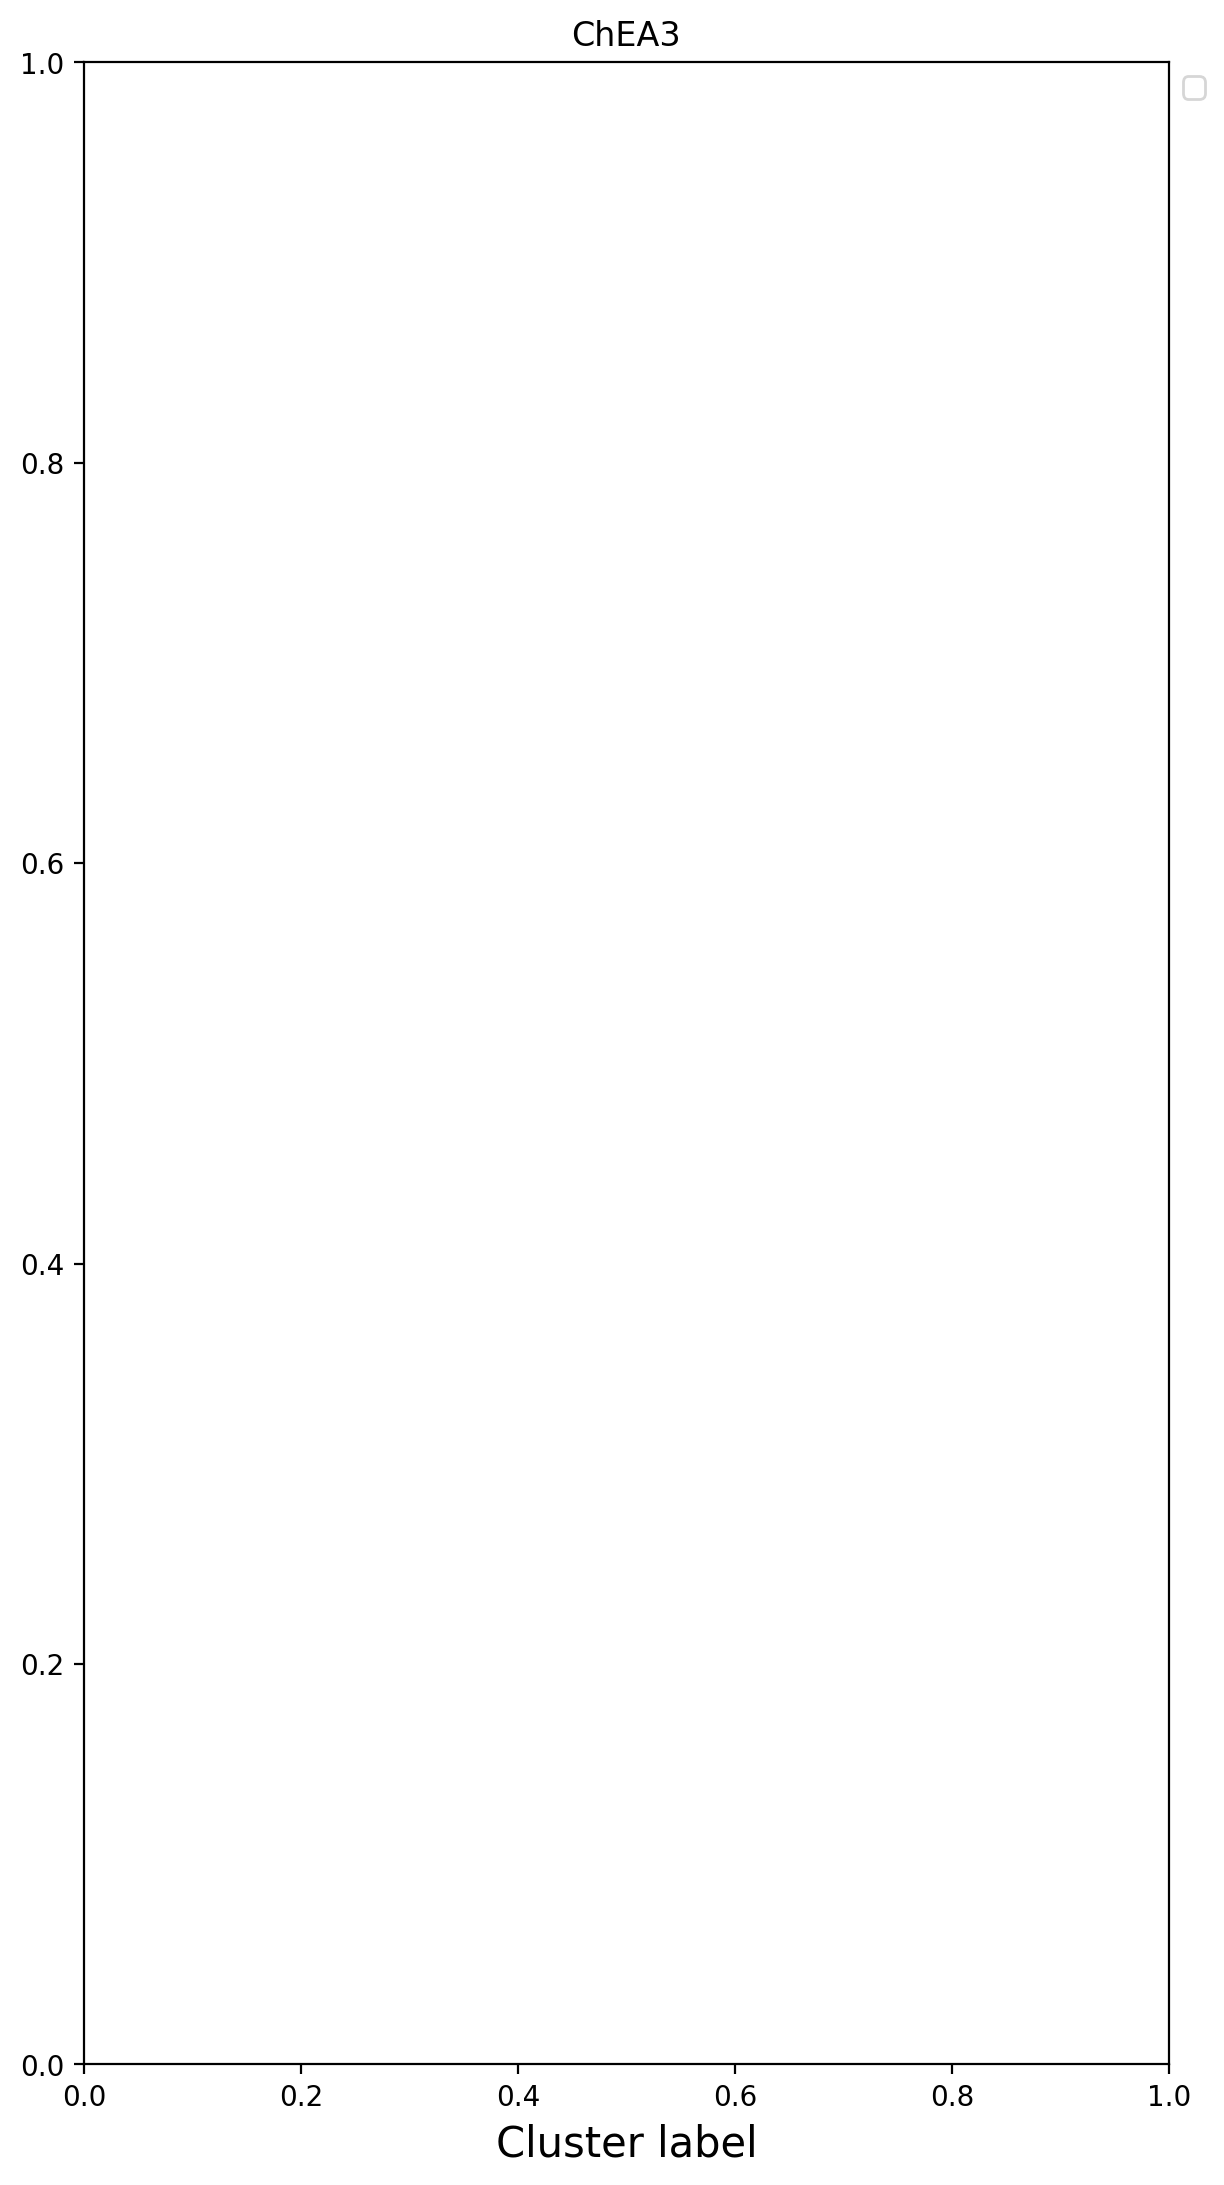

In [81]:
mpl.rcdefaults()
fig = plt.figure(figsize=(7, 13), dpi=100)

db_name = 'ChEA3'

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='Cluster',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

dict_keys(['TFAP2A', 'TFAP2B', 'TFAP2C', 'TFAP2D', 'TFAP2E', 'ARID3A', 'ARID3B', 'ARID3C', 'ARID5A', 'ARID5B', 'KDM5B', 'ARID2', 'AHCTF1', 'AHDC1', 'AKNA', 'ASH1L', 'CBX2', 'DNTTIP1', 'DOT1L', 'GLYR1', 'HMGA1', 'HMGA2', 'PHF20', 'PHF21A', 'PRR12', 'SCML4', 'SETBP1', 'SRCAP', 'FAM200B', 'SGSM2', 'ZBED1', 'ZBED2', 'ZBED3', 'ZBED4', 'ZBED5', 'ZBED6', 'ZBED9', 'AHR', 'AHRR', 'ARNT', 'ARNT2', 'ARNTL', 'ARNTL2', 'ASCL1', 'ASCL2', 'ASCL3', 'ASCL4', 'ASCL5', 'ATOH1', 'ATOH7', 'ATOH8', 'BHLHA15', 'BHLHA9', 'BHLHE22', 'BHLHE23', 'BHLHE40', 'BHLHE41', 'CCDC169-SOHLH2', 'CLOCK', 'EPAS1', 'FERD3L', 'FIGLA', 'HAND1', 'HAND2', 'HELT', 'HES1', 'HES2', 'HES3', 'HES4', 'HES5', 'HES6', 'HES7', 'HEY1', 'HEY2', 'HEYL', 'HIF1A', 'HIF3A', 'LYL1', 'MAX', 'MESP1', 'MESP2', 'MITF', 'MLX', 'MLXIP', 'MLXIPL', 'MNT', 'MSC', 'MSGN1', 'MXD1', 'MXD3', 'MXD4', 'MXI1', 'MYC', 'MYCL', 'MYCN', 'MYF5', 'MYF6', 'MYOD1', 'MYOG', 'NCOA1', 'NCOA2', 'NCOA3', 'NEUROD1', 'NEUROD2', 'NEUROD4', 'NEUROD6', 'NEUROG1', 'NEUROG2', 'NE

In [90]:
cluster_groups

label
LPL          0
SCN3B        0
RGS2         0
KIF21B       0
ST3GAL5      0
...        ...
EEF1G        5
COTL1        5
TRIR         5
CHST10       5
ZNF706       5

[65 rows x 1 columns]

In [92]:
res_dict['human-chimp'].index.intersection(chea_dict.keys())

Index(['AEBP1', 'AHR', 'AIRE', 'AR', 'ARID3A', 'ARID3B', 'ARID5B', 'ARNT',
       'ARX', 'ASCL1',
       ...
       'ZNF362', 'ZNF382', 'ZNF384', 'ZNF395', 'ZNF423', 'ZNF436', 'ZNF699',
       'ZNF76', 'ZNF804A', 'ZNF91'],
      dtype='object', length=612)